# **1. Business Problem Understanding**

## 1.1 Business Area

Travel insurance companies provide coverage for various risks associated with travel, such as trip cancellations, medical emergencies, and lost luggage. The company's profitability depends on accurately pricing policies to reflect the risk of claims and minimizing the payouts for claims while maintaining customer satisfaction.

## 1.2 Problem Statement

The company wants to predict which policyholders are likely to submit an insurance claim. This prediction allows the company to:

a. **Price insurance premiums more accurately:** By understanding the risk profiles of different customers, the company can adjust premiums to better reflect the likelihood of a claim.

b. **Offer tailored insurance products:** The company can offer specific insurance packages to customers based on their risk profiles, enhancing the relevance of their products.

c. **Improve risk management strategies:** By identifying high-risk customers, the company can take steps to mitigate potential losses, such as by adjusting terms or offering additional services.

d. **Enhance customer experience:** By identifying lower-risk customers, the company can offer personalized services or discounts, improving satisfaction and loyalty.

## 1.3 Goals

The primary goal of the machine learning model is to predict the Claim status (Yes/No) for each policyholder based on the available features. This prediction will enable the company to make informed decisions in several key areas:

- **Risk Assessment:** Improve the accuracy of risk assessments to minimize potential losses.
- **Premium Pricing:** Adjust pricing models to better align with the actual risk of claims.
- **Customer Segmentation:** Identify and reward low-risk customers while managing the risk posed by higher-risk customers.


In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

## **1.4 Dataset Overview**
- **Number of Records**: 44,328
- **Features**:
  - **Agency**: 16 unique agencies
  - **Agency Type**: 2 types (e.g., Airlines, Travel Agency)
  - **Distribution Channel**: 2 channels (e.g., Online, Offline)
  - **Product Name**: 26 different insurance products
  - **Gender**: 2 categories (M, F), but many missing values
  - **Duration**: Travel duration, ranging from -1 to 4,881 days (negative values need investigation)
  - **Destination**: 138 unique destinations
  - **Net Sales**: Sales amounts, ranging from -357.5 to 810.0 (negative values might be errors)
  - **Commission (in value)**: Commissions earned, ranging from 0 to 283.5
  - **Age**: Age of insured individuals, ranging from 0 to 118 years
  - **Claim**: Target variable, with 'Yes' and 'No' indicating if a claim was made (highly imbalanced towards 'No').

In [2]:
#Load Dataset
df = pd.read_csv("data_travel_insurance.csv")
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


In [3]:
# Number of Records
num_records = df.shape[0]
num_records

44328

In [4]:
# Features Information
agency_unique = df['Agency'].nunique()
agency_type_unique = df['Agency Type'].nunique()
distribution_channel_unique = df['Distribution Channel'].nunique()
product_name_unique = df['Product Name'].nunique()
gender_unique = df['Gender'].nunique()
destination_unique = df['Destination'].nunique()

In [5]:
# Summary statistics for numerical columns
duration_min = df['Duration'].min()
duration_max = df['Duration'].max()

In [6]:
net_sales_min = df['Net Sales'].min()
net_sales_max = df['Net Sales'].max()

In [7]:
commission_min = df['Commision (in value)'].min()
commission_max = df['Commision (in value)'].max()

In [8]:
age_min = df['Age'].min()
age_max = df['Age'].max()

In [9]:
# Claim counts
claim_counts = df['Claim'].value_counts()

In [10]:
# Display the results
dataset_overview = {
    "Number of Records": num_records,
    "Agency": agency_unique,
    "Agency Type": agency_type_unique,
    "Distribution Channel": distribution_channel_unique,
    "Product Name": product_name_unique,
    "Gender": gender_unique,
    "Duration": {"min": duration_min, "max": duration_max},
    "Destination": destination_unique,
    "Net Sales": {"min": net_sales_min, "max": net_sales_max},
    "Commission (in value)": {"min": commission_min, "max": commission_max},
    "Age": {"min": age_min, "max": age_max},
    "Claim Counts": claim_counts.to_dict()
}

dataset_overview

{'Number of Records': 44328,
 'Agency': 16,
 'Agency Type': 2,
 'Distribution Channel': 2,
 'Product Name': 26,
 'Gender': 2,
 'Duration': {'min': -1, 'max': 4881},
 'Destination': 138,
 'Net Sales': {'min': -357.5, 'max': 810.0},
 'Commission (in value)': {'min': 0.0, 'max': 283.5},
 'Age': {'min': 0, 'max': 118},
 'Claim Counts': {'No': 43651, 'Yes': 677}}

# **2. Data Cleaning**

1. Missing Values: The Gender field has significant missing values.
2. Outliers/Errors: Negative values in Duration and Net Sales suggest potential data entry errors that need cleaning.
3. Imbalance in Target Variable: The Claim field is highly imbalanced, with a majority of records being 'No' claims.
4. Data duplicates

## 2.1 Missing Values

Missing Data Handling: Since the Gender column had a significant amount of missing data (31,647 missing values), the decision was made to drop this column rather than attempt to fill in the missing data.

Dataset Integrity: After dropping this column, the dataset now only contains columns with no missing data, ensuring that further analysis and model building can proceed without issues related to missing values.

In [11]:
# Checking Missing Values, Outliers/Errors, and Imbalance

# Missing Values
missing_values = df.isnull().sum()
missing_values

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Gender                  31647
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Age                         0
Claim                       0
dtype: int64

In [12]:
# Drop the 'Gender' column from the dataset
df.drop(columns=['Gender'], inplace=True)

## 2.2 Imbalance Target

The Claim column has two possible values: No (meaning no claim was made) and Yes (meaning a claim was made).

The output shows that approximately 98.47% of the instances in the dataset are No (no claim), while only about 1.53% are Yes (a claim was made).

This distribution is typical and desirable for an insurance company. The low percentage of claims (Yes) indicates that most policyholders do not need to use their insurance, which is a sign of effective risk management by the company.

If the distribution were more balanced or skewed towards the Yes claims, it could indicate potential issues, such as underwriting policies that are too lenient, leading to higher-than-expected claims, which could decrease the company's profitability.

In [13]:
# Imbalance in Target Variable
claim_distribution = df['Claim'].value_counts(normalize=True)
claim_distribution

Claim
No     0.984727
Yes    0.015273
Name: proportion, dtype: float64

## 2.3 Outliers Value in Duration and Net Sales (Negative Value)

This process will delete all the data that have a negative value. Due to there is no reasonable statement to legitimate why the data is negative

In [14]:
# Outliers/Errors
negative_duration = df[df['Duration'] < 0]
negative_net_sales = df[df['Net Sales'] < 0]

In [15]:
negative_duration

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
26228,JZI,Airlines,Online,Basic Plan,-1,MALAYSIA,18.0,6.3,118,No
26494,JZI,Airlines,Online,Basic Plan,-1,BRUNEI DARUSSALAM,18.0,6.3,118,No


In [16]:
negative_net_sales

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
94,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,-216.75,54.19,36,No
116,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,430,AUSTRALIA,-59.40,35.64,41,No
121,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,77,JAPAN,-29.70,17.82,59,No
199,EPX,Travel Agency,Online,Cancellation Plan,29,HONG KONG,-12.00,0.00,36,No
241,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,57,AUSTRALIA,-59.40,35.64,28,No
...,...,...,...,...,...,...,...,...,...,...
43694,EPX,Travel Agency,Online,2 way Comprehensive Plan,140,UNITED STATES,-98.00,0.00,29,No
43743,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,23,MALAYSIA,-29.70,17.82,29,No
43751,EPX,Travel Agency,Online,2 way Comprehensive Plan,147,SPAIN,-68.00,0.00,36,No
43858,EPX,Travel Agency,Online,Cancellation Plan,49,UNITED KINGDOM,-68.00,0.00,36,No


In [17]:
# Remove rows with negative values
df = df[df['Duration'] >= 0]
df = df[df['Net Sales'] >= 0]

## 2.4 Handling Duplicate Data

Drop data that duplicated in dataset

In [18]:
# Check for duplicates in the dataset
duplicate_rows = df[df.duplicated()]

# Number of duplicate rows
num_duplicates = duplicate_rows.shape[0]

In [19]:
df.duplicated().value_counts()

False    38844
True      4999
Name: count, dtype: int64

In [20]:
duplicate_rows

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
331,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.00,36,No
360,EPX,Travel Agency,Online,Cancellation Plan,6,MALAYSIA,10.0,0.00,36,No
473,EPX,Travel Agency,Online,Cancellation Plan,11,MALAYSIA,10.0,0.00,36,No
488,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.00,36,No
636,EPX,Travel Agency,Online,1 way Comprehensive Plan,3,MALAYSIA,20.0,0.00,36,No
...,...,...,...,...,...,...,...,...,...,...
44309,EPX,Travel Agency,Online,2 way Comprehensive Plan,49,VIET NAM,20.0,0.00,36,No
44311,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,5,THAILAND,29.7,17.82,38,No
44313,EPX,Travel Agency,Online,Cancellation Plan,5,CHINA,14.0,0.00,36,No
44315,EPX,Travel Agency,Online,1 way Comprehensive Plan,5,THAILAND,20.0,0.00,36,No


In [21]:
num_duplicates

4999

In [22]:
duplicates = df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

In [23]:
duplicates

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
10217,ART,Airlines,Online,24 Protect,3,MALAYSIA,4.99,1.75,48,No
22009,ART,Airlines,Online,24 Protect,3,MALAYSIA,4.99,1.75,48,No
19436,ART,Airlines,Online,Value Plan,18,CHINA,61.00,21.35,118,No
31570,ART,Airlines,Online,Value Plan,18,CHINA,61.00,21.35,118,No
38456,ART,Airlines,Online,Value Plan,31,THAILAND,29.00,10.15,118,No
...,...,...,...,...,...,...,...,...,...,...
7886,TTW,Travel Agency,Offline,Child Comprehensive Plan,369,SINGAPORE,74.00,0.00,9,No
10520,TTW,Travel Agency,Offline,Individual Comprehensive Plan,364,SINGAPORE,97.00,0.00,33,No
32634,TTW,Travel Agency,Offline,Individual Comprehensive Plan,364,SINGAPORE,97.00,0.00,33,No
23563,TTW,Travel Agency,Offline,Individual Comprehensive Plan,364,SINGAPORE,97.00,0.00,42,No


In [24]:
# Display the duplicates along with their row indices
duplicate_indices = duplicates.index
duplicate_indices

Index([10217, 22009, 19436, 31570, 38456, 43985,  9586, 26123, 10496, 14317,
       ...
       42018, 42853,  7217, 14092,  2008,  7886, 10520, 32634, 23563, 29771],
      dtype='int64', length=7823)

In [25]:
# Show the rows with duplication details
df.loc[duplicate_indices]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
10217,ART,Airlines,Online,24 Protect,3,MALAYSIA,4.99,1.75,48,No
22009,ART,Airlines,Online,24 Protect,3,MALAYSIA,4.99,1.75,48,No
19436,ART,Airlines,Online,Value Plan,18,CHINA,61.00,21.35,118,No
31570,ART,Airlines,Online,Value Plan,18,CHINA,61.00,21.35,118,No
38456,ART,Airlines,Online,Value Plan,31,THAILAND,29.00,10.15,118,No
...,...,...,...,...,...,...,...,...,...,...
7886,TTW,Travel Agency,Offline,Child Comprehensive Plan,369,SINGAPORE,74.00,0.00,9,No
10520,TTW,Travel Agency,Offline,Individual Comprehensive Plan,364,SINGAPORE,97.00,0.00,33,No
32634,TTW,Travel Agency,Offline,Individual Comprehensive Plan,364,SINGAPORE,97.00,0.00,33,No
23563,TTW,Travel Agency,Offline,Individual Comprehensive Plan,364,SINGAPORE,97.00,0.00,42,No


In [26]:
# Optionally, remove duplicates
df = df.drop_duplicates()

In [27]:
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No


In [28]:
# Imbalance in Target Variable
claim_distribution = df['Claim'].value_counts(normalize=True)
claim_distribution

Claim
No     0.982674
Yes    0.017326
Name: proportion, dtype: float64

In [29]:
df['Claim'].value_counts()

Claim
No     38171
Yes      673
Name: count, dtype: int64

## 2.5 Creating New Columns

Create a new column to better understanding about the distribution of age through the data. This could be new feature which generate better model result

In [30]:
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66+'])

# **3. Exploratory Data Analysis**

## 3.1 Distribution Analysis

### 3.1.1 Average Commission by Claim Status

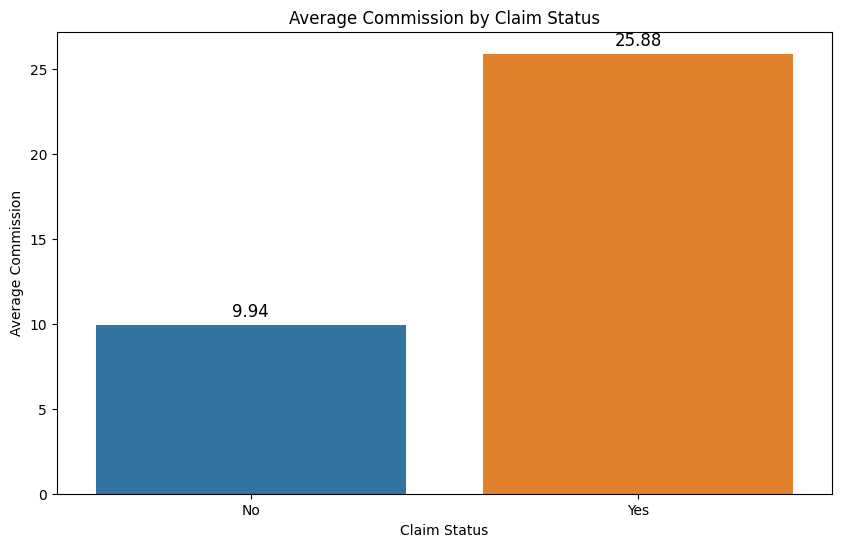

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot with average commission by claim status
plt.figure(figsize=(10, 6))
avg_commission = df.groupby('Claim')['Commision (in value)'].mean()
bar_plot = sns.barplot(x=avg_commission.index, y=avg_commission.values, palette=['#1f77b4', '#ff7f0e'])

# Add labels on each bar with different colors
for index, value in enumerate(avg_commission):
    plt.text(index, value + 0.5, f'{value:.2f}', ha='center', fontsize=12, color='black')

plt.title('Average Commission by Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Average Commission')
plt.show()

1. **Interpretation:**

   This visualization suggests that there might be a pattern where higher commissions are associated with claims, but the situations where no claims are made can result in a wider range of commission values. This could imply that certain conditions leading to no claims might still result in substantial commissions, potentially due to specific policies or high-value sales that don't result in a claim.

2. **This could lead to further questions:**

   2.1 Why are commissions so high in certain no-claim scenarios?

   2.2 Is there a policy structure or sales strategy that leads to this distribution?

   2.3 What can be done to optimize commission structures in relation to claim status?

3. **Implications:**

   These insights can guide further analysis or policy adjustments to better align commission structures with company objectives.

### 3.1.2 Distribution of Commission by Claim Status

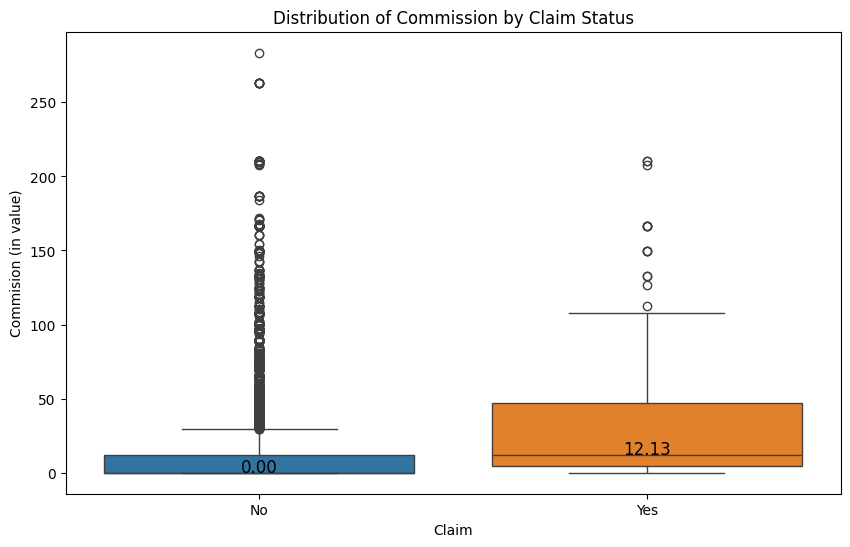

In [32]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='Claim', y='Commision (in value)', data=df, palette=['#1f77b4', '#ff7f0e'])

# Add median values on the boxplot with different colors
medians = df.groupby('Claim')['Commision (in value)'].median()
for index, median in enumerate(medians):
    plt.text(index, median + 0.5, f'{median:.2f}', ha='center', fontsize=12, color='black')

plt.title('Distribution of Commission by Claim Status')
plt.show()

1. **Interpretation:**

   This visualization suggests that when claims are made, the associated commission tends to be higher on average. This might indicate that higher-value sales or policies, which offer larger commissions, are also more likely to result in claims.

2. **Potential Implications:**

   2.1 Policy Review: If higher commissions are tied to higher claim rates, it could be beneficial for the insurance company to review these policies. They might need to assess whether the higher risk of claims justifies the higher commissions.

   2.2 Risk Management: This data might suggest a need for better risk management strategies for high-commission policies, perhaps by offering different terms or adjusting pricing structures.

   2.3 Sales Strategies: Understanding this relationship could help the sales team in structuring commissions in a way that aligns better with company profitability goals, ensuring that high commissions do not lead to disproportionately high claim rates.

### 3.1.3 Average Net Sales by Claim Status

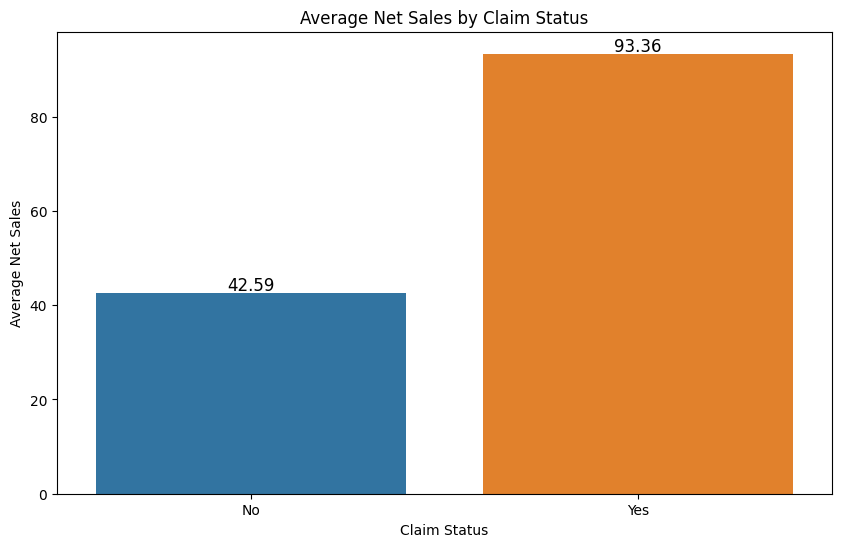

In [33]:
# Bar plot with average net sales by claim status
plt.figure(figsize=(10, 6))
avg_net_sales = df.groupby('Claim')['Net Sales'].mean()
bar_plot = sns.barplot(x=avg_net_sales.index, y=avg_net_sales.values, palette=['#1f77b4', '#ff7f0e'])

# Add labels on each bar with different colors
for index, value in enumerate(avg_net_sales):
    plt.text(index, value + 0.5, f'{value:.2f}', ha='center', fontsize=12, color='black')

plt.title('Average Net Sales by Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Average Net Sales')
plt.show()

1. **Average Net Sales for Claims (Yes) is Higher:** 
   - The average net sales for instances where a claim was made ("Yes") is significantly higher (93.36) compared to instances where no claim was made (42.60).

2. **Implication for the Business:**
   1. This could indicate that policies with higher net sales amounts are more likely to result in claims.
   2. For the insurance company, this might suggest that high-value policies are associated with higher risk, as they are more frequently claimed.

3. **Possible Business Action:**
   1. The company might consider re-evaluating the pricing or underwriting policies for high-value insurance products to mitigate potential risks.
   2. There could also be a need to investigate why higher net sales are correlated with higher claims and whether this pattern is sustainable for the business.


### 3.1.4 Distribution of Net Sales by Claim Status

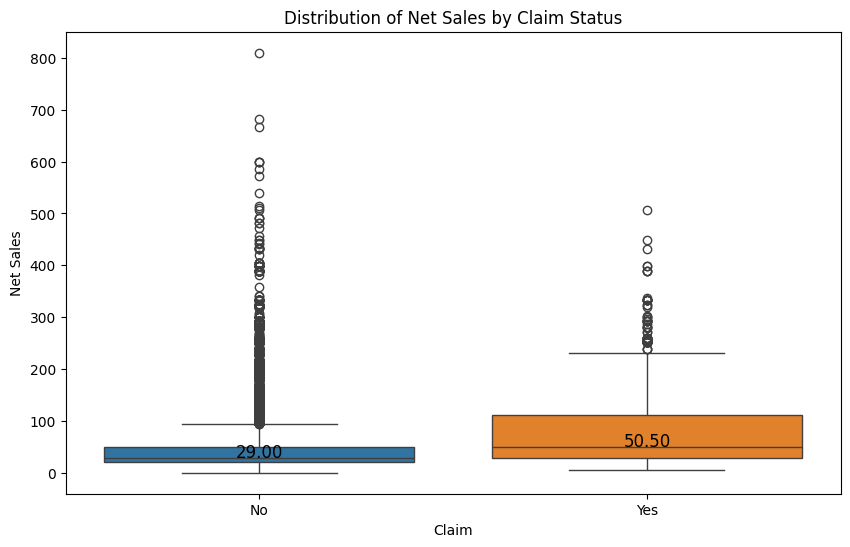

In [34]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='Claim', y='Net Sales', data=df, palette=['#1f77b4', '#ff7f0e'])

# Add median values on the boxplot with different colors
medians = df.groupby('Claim')['Net Sales'].median()
for index, median in enumerate(medians):
    plt.text(index, median + 0.5, f'{median:.2f}', ha='center', fontsize=12, color='black')

plt.title('Distribution of Net Sales by Claim Status')
plt.show()

1. **Median Net Sales:**
   1. The median net sales for policies with no claims ("No") is 29.00.
   2. The median net sales for policies with claims ("Yes") is higher at 50.50.

2. **Interquartile Range (IQR):**
   1. The IQR (the range between the first quartile and the third quartile) is wider for the "Yes" claim status, suggesting greater variability in the net sales amounts for policies that result in claims.
   2. In contrast, the IQR for "No" is narrower, indicating less variability in net sales for policies without claims.

3. **Outliers:**
   1. Both "No" and "Yes" categories have outliers, but the "No" category has many more outliers with higher net sales values. This indicates that while most of the "No" claims have lower net sales, there are still some policies with high net sales that do not result in claims.
   2. The "Yes" category has fewer outliers, suggesting that higher net sales policies that result in claims are less common.

4. **Implications:**
   1. The higher median and wider IQR for "Yes" claims suggest that higher net sales are associated with a greater likelihood of a claim being made. This could indicate that customers with higher value policies are more likely to use their insurance.
   2. The presence of many outliers in the "No" category suggests that while high net sales are generally associated with claims, there are still significant instances where high-value policies do not result in claims.

### 3.1.4 Distribution of Each Features

1. Duration:

Distribution: The Duration feature appears to be highly right-skewed, with a significant concentration of values at the lower end of the distribution. Most durations are clustered close to zero, with a long tail extending towards higher durations.

Interpretation: The majority of trips or policies have relatively short durations, with only a few instances having much longer durations. This could be due to the nature of the travel policies, where short trips are more common.

2. Net Sales:

Distribution: Similar to Duration, the Net Sales feature is also right-skewed. Most values are concentrated near zero, with fewer instances having high net sales.

Interpretation: This indicates that most insurance policies have lower net sales, with only a few policies generating higher sales. This could imply that the company sells a large volume of low-value policies and a smaller number of high-value policies.

3. Commision (in value):

Distribution: The distribution of Commision (in value) is also right-skewed, with most values being small and a few larger values.

Interpretation: The majority of commissions are relatively low, with only a few instances of higher commissions. This might suggest that higher commissions are associated with higher-value policies, but these are less frequent.

4. Age:

Distribution: The Age feature shows a more bell-shaped distribution, centered around the 30-40 age range. There is a smaller number of younger and older individuals, with a sharp decline in frequency as the age increases.

Interpretation: This distribution suggests that the majority of policyholders are middle-aged, with fewer younger and older policyholders. This could reflect the target demographic for travel insurance, where middle-aged individuals are more likely to purchase policies.

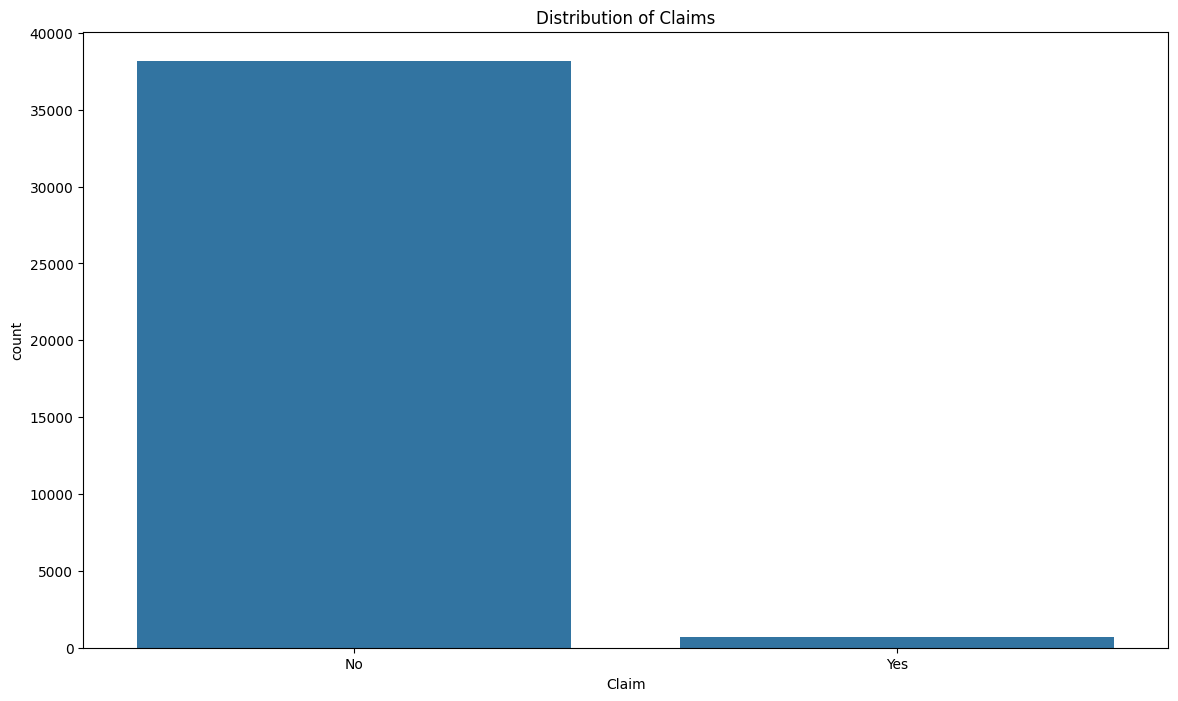

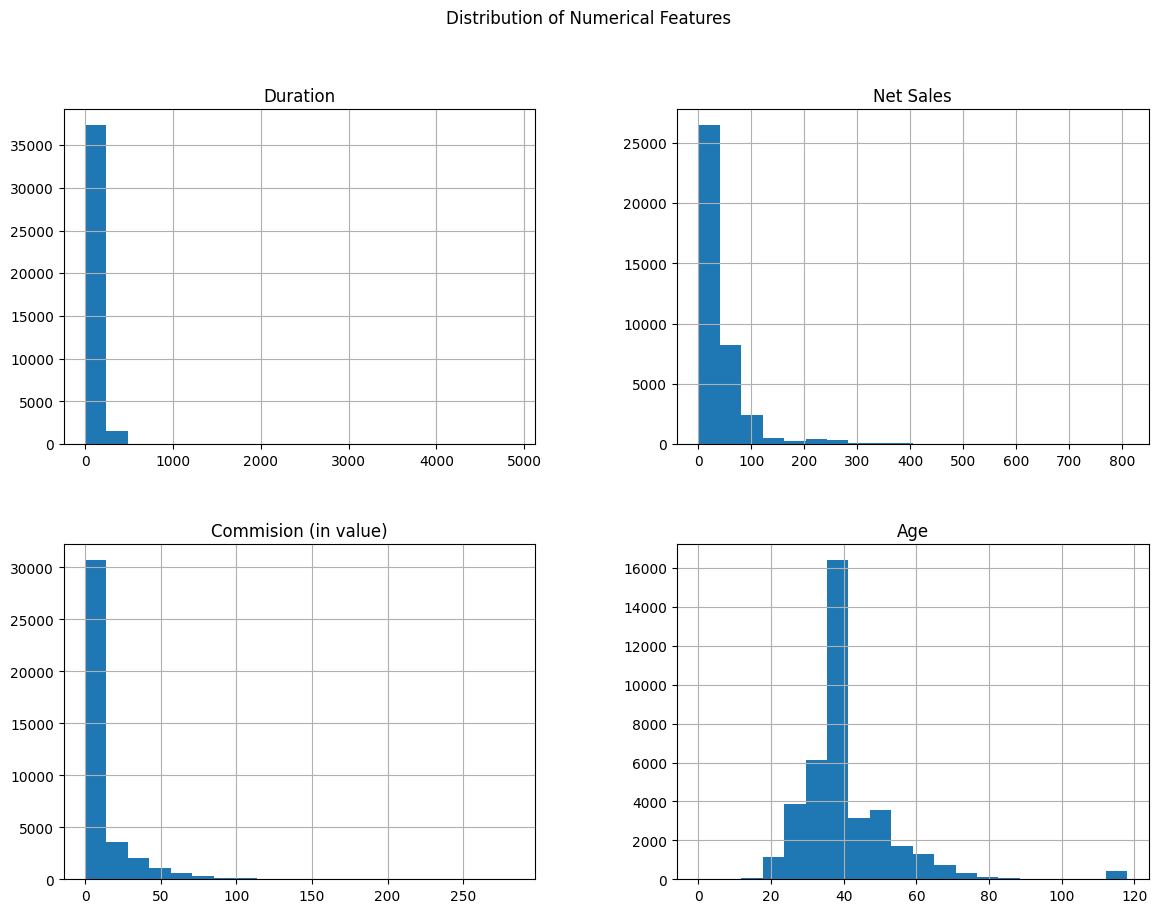

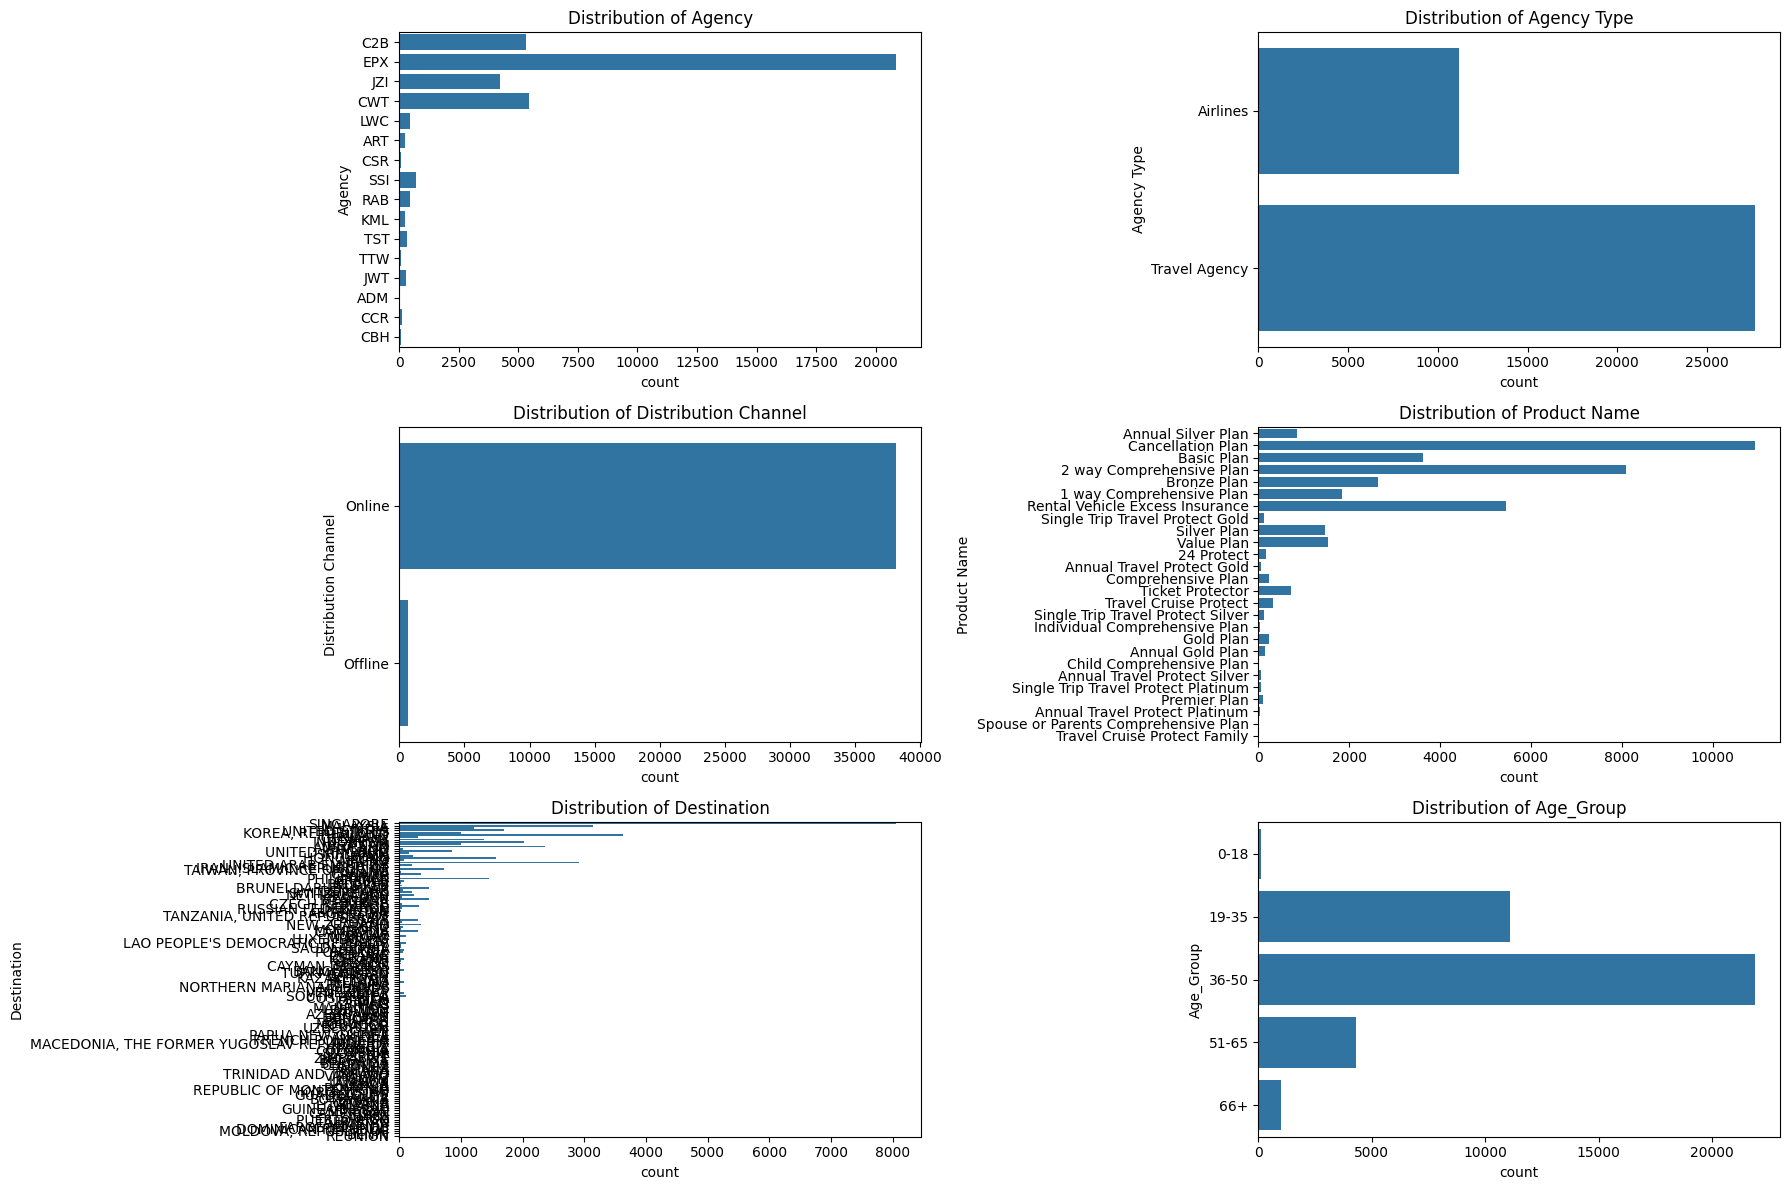

In [35]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Distribution of the 'Claim' variable
sns.countplot(x='Claim', data=df)
plt.title('Distribution of Claims')
plt.show()

# Distribution of numerical features
df.hist(figsize=(14, 10), bins=20)
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Distribution of categorical features
categorical_features = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination', 'Age_Group']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

for i, feature in enumerate(categorical_features):
    sns.countplot(y=feature, data=df, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

### 3.1.5 Re-Check Outliers in Duration

There are a lot of data which have a high duration in travel time. Due to regulation among global countries, the maximum day that people can travel accross is below 1000 days. Therefore we should delete this outliers to make a good model

In [36]:
df[df['Duration'] < 1000]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Age_Group
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No,51-65
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No,19-35
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No,19-35
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No,51-65
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No,19-35
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes,36-50
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No,36-50
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No,36-50
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No,36-50


In [37]:
df[df['Duration'] > 1000]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Age_Group
87,SSI,Airlines,Online,Ticket Protector,4736,SINGAPORE,0.32,0.09,48,No,36-50
4678,SSI,Airlines,Online,Ticket Protector,4857,SINGAPORE,0.32,0.09,48,No,36-50
10172,SSI,Airlines,Online,Ticket Protector,4815,SINGAPORE,0.32,0.09,48,No,36-50
12140,SSI,Airlines,Online,Ticket Protector,4652,SINGAPORE,0.32,0.09,48,No,36-50
19497,SSI,Airlines,Online,Ticket Protector,4881,SINGAPORE,0.13,0.04,48,No,36-50
20038,SSI,Airlines,Online,Ticket Protector,4844,SINGAPORE,0.32,0.09,48,No,36-50
22215,SSI,Airlines,Online,Ticket Protector,4580,SINGAPORE,0.32,0.09,48,No,36-50
25606,SSI,Airlines,Online,Ticket Protector,4685,SINGAPORE,0.32,0.09,48,No,36-50
28032,SSI,Airlines,Online,Ticket Protector,4829,SINGAPORE,0.32,0.09,48,No,36-50
37207,SSI,Airlines,Online,Ticket Protector,4609,SINGAPORE,0.32,0.09,48,No,36-50


In [38]:
# Investigate records where Duration exceeds 1000 days
outliers_duration = df[df['Duration'] > 1000]
print(outliers_duration)

      Agency Agency Type Distribution Channel      Product Name  Duration  \
87       SSI    Airlines               Online  Ticket Protector      4736   
4678     SSI    Airlines               Online  Ticket Protector      4857   
10172    SSI    Airlines               Online  Ticket Protector      4815   
12140    SSI    Airlines               Online  Ticket Protector      4652   
19497    SSI    Airlines               Online  Ticket Protector      4881   
20038    SSI    Airlines               Online  Ticket Protector      4844   
22215    SSI    Airlines               Online  Ticket Protector      4580   
25606    SSI    Airlines               Online  Ticket Protector      4685   
28032    SSI    Airlines               Online  Ticket Protector      4829   
37207    SSI    Airlines               Online  Ticket Protector      4609   
38536    SSI    Airlines               Online  Ticket Protector      4784   
42584    SSI    Airlines               Online  Ticket Protector      4831   

In [39]:
# Remove records where Duration exceeds 1000 days
df = df[df['Duration'] <= 1000]

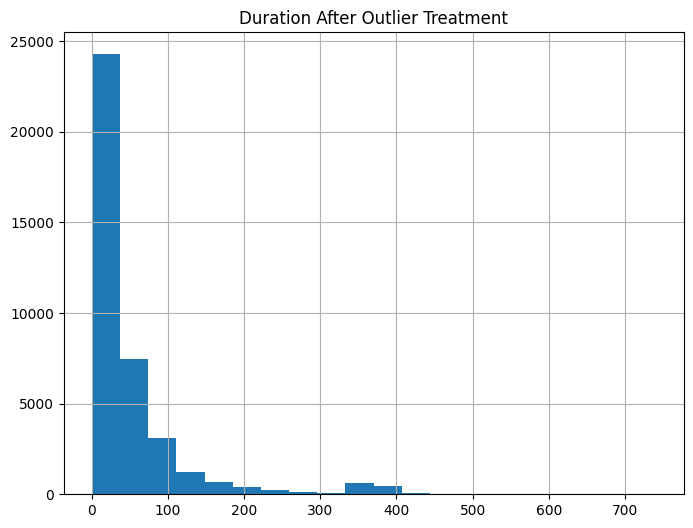

In [40]:
# Re-plot the histogram
df['Duration'].hist(bins=20, figsize=(8, 6))
plt.title('Duration After Outlier Treatment')
plt.show()

In [41]:
df[df['Net Sales'] < 200]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Age_Group
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No,19-35
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No,19-35
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No,51-65
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No,19-35
5,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.00,36,No,36-50
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes,36-50
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No,36-50
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No,36-50
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No,36-50


In [42]:
df[df['Net Sales'] > 800]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Age_Group
42971,JZI,Airlines,Online,Value Plan,139,UNITED STATES,810.0,283.5,118,No,NaN


In [43]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,38831.000000,38831.000000,38831.000000,38831.000000
mean,50.386289,43.481791,10.220671,39.823878
std,74.153889,48.351129,20.207005,13.190028
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,19.800000,0.000000,35.000000
50%,25.000000,29.000000,0.000000,36.000000
75%,56.000000,50.000000,11.880000,44.000000
max,740.000000,810.000000,283.500000,118.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38831 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Agency                38831 non-null  object  
 1   Agency Type           38831 non-null  object  
 2   Distribution Channel  38831 non-null  object  
 3   Product Name          38831 non-null  object  
 4   Duration              38831 non-null  int64   
 5   Destination           38831 non-null  object  
 6   Net Sales             38831 non-null  float64 
 7   Commision (in value)  38831 non-null  float64 
 8   Age                   38831 non-null  int64   
 9   Claim                 38831 non-null  object  
 10  Age_Group             38418 non-null  category
dtypes: category(1), float64(2), int64(2), object(6)
memory usage: 3.3+ MB


In [45]:
df.isnull().sum()

Agency                    0
Agency Type               0
Distribution Channel      0
Product Name              0
Duration                  0
Destination               0
Net Sales                 0
Commision (in value)      0
Age                       0
Claim                     0
Age_Group               413
dtype: int64

### 3.1.6 Correlation Analysis Between Duration and Claim

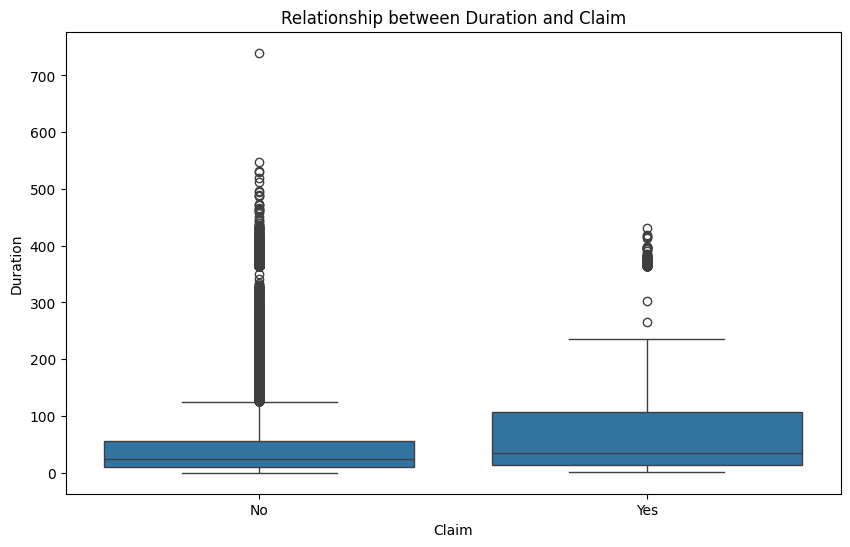

In [46]:
# Relationship between Duration and Claim
plt.figure(figsize=(10, 6))
sns.boxplot(x='Claim', y='Duration', data=df)
plt.title('Relationship between Duration and Claim')
plt.show()

### 3.1.7 Correlation Analysis Between All Features

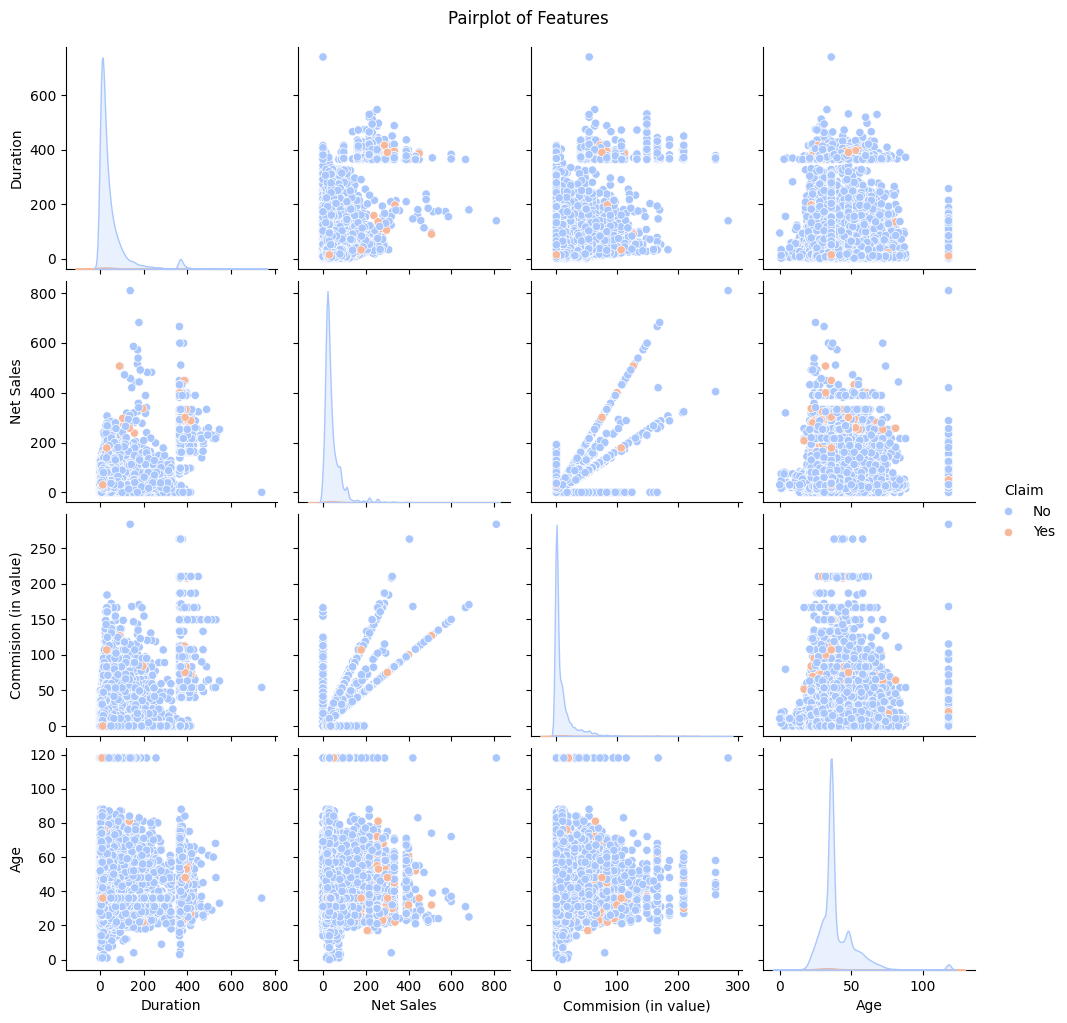

In [47]:
# Pairplot to see relationships between features
sns.pairplot(df, hue='Claim', palette='coolwarm')
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()

### 3.1.8 The relationship between age and net sales

Interpretation:
1. **Distribution of Net Sales Across Ages**:
   - The majority of net sales values are clustered below 300, with a significant spread across different age groups, particularly between ages 20 and 60.
   - Similar to the previous scatter plot, the density of "No" claims (blue dots) is much higher, indicating that net sales are predominantly associated with no claims across most age groups.

2. **Claims vs. No Claims**:
   - The orange dots represent instances where a claim was made. These are interspersed among the "No" claims but appear more frequently in certain ranges of net sales, particularly between 100 and 300.
   - Unlike the commission scatter plot, there seems to be a slight pattern where higher net sales may correlate with a higher likelihood of claims, though the differentiation is still not stark.

3. **Potential Outliers**:
   - There are a few outliers in the dataset where individuals have high net sales (above 500), and these instances include both claims and no claims. This suggests that while high net sales can lead to claims, it is not a guaranteed outcome.

Implications:
- **Partial Differentiation**: The scatter plot indicates that net sales, when considered alongside age, might provide some predictive power in determining the likelihood of a claim, particularly within specific ranges of net sales.
- **Further Feature Exploration**: While age and net sales alone offer some insight, it may be necessary to explore other features or combinations of features to better model the likelihood of claims. The observed pattern suggests that there could be a more complex relationship between age, net sales, and claim outcomes.

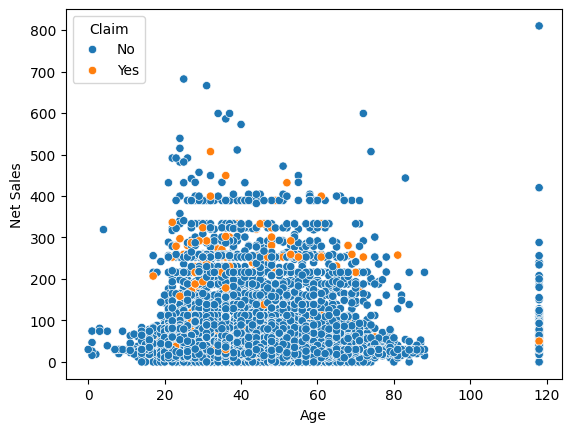

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example scatter plot
sns.scatterplot(x='Age', y='Net Sales', data=df, hue='Claim')
plt.show()

### 3.1.9 The relationship between age and commission values

Interpretation:
1. **Distribution of Commissions Across Ages**:
   - The plot shows that commissions are mostly concentrated below 150, with a wide spread of ages from 0 to around 80 years.
   - The majority of data points, particularly those with no claims ("No"), are densely packed, indicating that most commissions are clustered within certain age ranges, especially between ages 20 and 60.

2. **Claims vs. No Claims**:
   - The orange dots represent instances where a claim was made. These are scattered throughout the plot, indicating that claims can occur across various ages and commission levels.
   - However, the density of "No" claims (blue dots) is much higher, consistent with the overall imbalance in the dataset where "No" claims are more common.
   - There are no clear separations between "Yes" and "No" claims based on age and commission alone, suggesting that other features might be needed to better differentiate between the two categories.

3. **Potential Outliers**:
   - There are a few outliers where individuals at very young ages (close to 0) and older ages (over 100) are associated with higher commissions. These could be worth investigating further to understand if these data points are valid or if they represent anomalies.

Implications:
- **No Clear Differentiation**: The scatter plot suggests that age and commission alone may not be sufficient to predict whether a claim will be made, as claims are spread across the entire range of ages and commissions.
- **Further Analysis**: It would be beneficial to explore additional features or interactions between features to improve the model's ability to distinguish between claim outcomes. This plot indicates the need for more complex modeling approaches that consider multiple variables simultaneously.

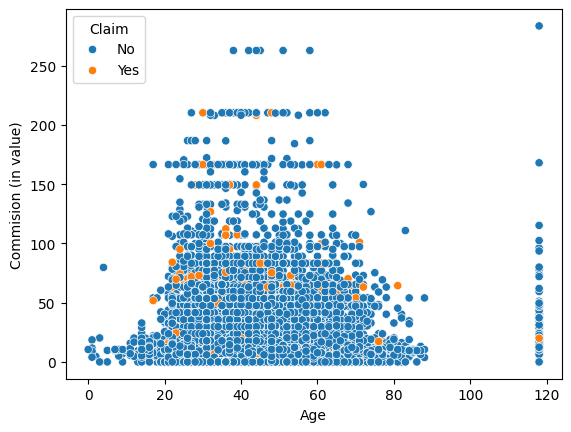

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example scatter plot
sns.scatterplot(x='Age', y='Commision (in value)', hue='Claim',data=df)
plt.show()

### 3.1.10 Distribution of Age by Claim Status with Detailed Statistics

**Interpretation:**

    1. Median Age: For those who did not make a claim ("No"), the median age is 35 years. For those who made a claim ("Yes"), the median age is slightly lower, at 36 years.

    2. Interquartile Range (IQR): Both groups have a similar IQR, ranging from approximately 30 to 44 years, which suggests that the middle 50% of ages for both claimants and non-claimants are within this range.

    3. Minimum and Maximum Ages: The minimum age for non-claimants is 0, and for claimants, it is 14. The maximum age is 118 for both groups, indicating the presence of older individuals in both groups.

**Implications:**

    1. The slight difference in median ages between those who made claims and those who did not could imply that younger individuals are more likely to make claims, though the difference is not significant.

    2. The range and distribution of ages are quite similar between both groups, indicating that age alone might not be a strong differentiator in predicting whether an individual will make a claim.
    
    3. The presence of younger individuals in the non-claimant group (with a minimum age of 0) suggests that there could be different insurance products or circumstances that affect this group, which could be worth investigating further.

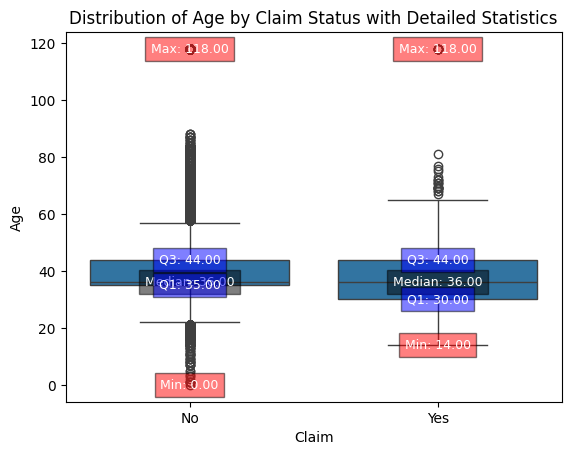

In [50]:
# Create the boxplot
sns.boxplot(x='Claim', y='Age', data=df)

# Annotate the plot with detailed statistics
# Calculate the median, Q1, Q3, and other statistics for each category
for claim in df['Claim'].unique():
    # Get the subset of data for each claim category
    subset = df[df['Claim'] == claim]['Age']
    
    # Calculate statistics
    median = subset.median()
    q1 = subset.quantile(0.25)
    q3 = subset.quantile(0.75)
    min_val = subset.min()
    max_val = subset.max()

    # Find the x-coordinate for annotation (0 for 'No' and 1 for 'Yes')
    x_coord = 0 if claim == 'No' else 1

    # Annotate the statistics on the plot
    plt.text(x=x_coord, y=median, s=f'Median: {median:.2f}', ha='center', va='center', fontsize=9, color='white', bbox=dict(facecolor='black', alpha=0.5))
    plt.text(x=x_coord, y=q1, s=f'Q1: {q1:.2f}', ha='center', va='center', fontsize=9, color='white', bbox=dict(facecolor='blue', alpha=0.5))
    plt.text(x=x_coord, y=q3, s=f'Q3: {q3:.2f}', ha='center', va='center', fontsize=9, color='white', bbox=dict(facecolor='blue', alpha=0.5))
    plt.text(x=x_coord, y=min_val, s=f'Min: {min_val:.2f}', ha='center', va='center', fontsize=9, color='white', bbox=dict(facecolor='red', alpha=0.5))
    plt.text(x=x_coord, y=max_val, s=f'Max: {max_val:.2f}', ha='center', va='center', fontsize=9, color='white', bbox=dict(facecolor='red', alpha=0.5))

plt.title('Distribution of Age by Claim Status with Detailed Statistics')
plt.show()


In [51]:
# Aggregating 'Net Sales' by 'Age_Group'
net_sales_by_age_group = df.groupby('Age_Group')['Net Sales'].mean()

# Aggregating 'Commision (in value)' by 'Age_Group'
commission_by_age_group = df.groupby('Age_Group')['Commision (in value)'].mean()

# Display the results
print(net_sales_by_age_group)
print(commission_by_age_group)

Age_Group
0-18     45.538115
19-35    45.505782
36-50    40.872512
51-65    48.824619
66+      48.027994
Name: Net Sales, dtype: float64
Age_Group
0-18     13.622459
19-35    13.682329
36-50     6.726892
51-65    16.863786
66+      14.159461
Name: Commision (in value), dtype: float64


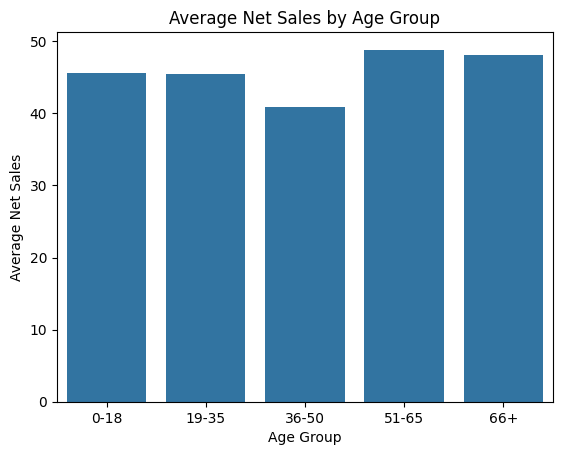

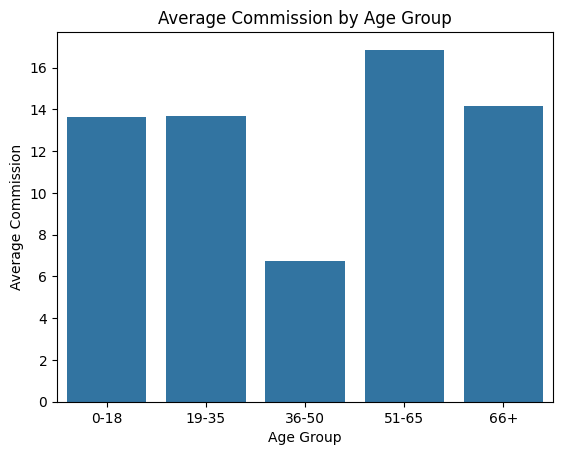

In [52]:
# Plotting the average Net Sales by Age Group
sns.barplot(x=net_sales_by_age_group.index, y=net_sales_by_age_group.values)
plt.title('Average Net Sales by Age Group')
plt.ylabel('Average Net Sales')
plt.xlabel('Age Group')
plt.show()

# Plotting the average Commission by Age Group
sns.barplot(x=commission_by_age_group.index, y=commission_by_age_group.values)
plt.title('Average Commission by Age Group')
plt.ylabel('Average Commission')
plt.xlabel('Age Group')
plt.show()

# **4. Data Analysis**

In [53]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,38831.000000,38831.000000,38831.000000,38831.000000
mean,50.386289,43.481791,10.220671,39.823878
std,74.153889,48.351129,20.207005,13.190028
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,19.800000,0.000000,35.000000
50%,25.000000,29.000000,0.000000,36.000000
75%,56.000000,50.000000,11.880000,44.000000
max,740.000000,810.000000,283.500000,118.000000


## 4.1 Customer Age Mean based on Agency

In [54]:
df.groupby('Agency')['Age'].mean()  # Correct

Agency
ADM     24.727273
ART     58.417040
C2B     38.090481
CBH     56.417910
CCR     63.929825
CSR     57.661765
CWT     40.478380
EPX     37.085247
JWT    118.000000
JZI     44.415480
KML     47.859649
LWC     40.158482
RAB     43.717540
SSI     48.502874
TST     49.886850
TTW     40.045455
Name: Age, dtype: float64

## 4.2 Agency Performance Based on Good performance targetting for lower Risk Customer

In [55]:
# Group the data by 'Agency' and 'Claim', and then sum the 'Commision (in value)'
commission_by_agency_claim = df.groupby(['Agency', 'Claim'])['Commision (in value)'].sum().unstack()

# Display the result
print("Total Commission by Agency and Claim Status (Yes/No):")
commission_by_agency_claim.sort_values(by=['No','Yes'],ascending=False)

Total Commission by Agency and Claim Status (Yes/No):


Claim,No,Yes
Agency,,
CWT,174998.34,2809.62
C2B,96612.15,11410.83
JZI,49841.75,365.75
LWC,30634.72,2542.64
JWT,7356.80,132.00
KML,5391.06,82.84
TST,3424.75,21.00
RAB,3233.20,6.00
ART,2405.19,NaN


## 4.3 Agency Performance By Total Sales that they Achieved based on Claim Status

In [56]:
# Group the data by 'Agency' and 'Claim', and then sum the 'Net Sales'
sales_by_agency_claim = df.groupby(['Agency', 'Claim'])['Net Sales'].sum().unstack()

# Display the result
print("Total Sales by Agency and Claim Status (Yes/No):")
sales_by_agency_claim.sort_values(by=['No','Yes'],ascending=False)

Total Sales by Agency and Claim Status (Yes/No):


Claim,No,Yes
Agency,,
EPX,729474.00,6691.00
C2B,375025.11,45641.45
CWT,257409.90,4682.70
JZI,139212.00,1045.00
LWC,46299.30,3911.70
JWT,18229.00,330.00
KML,14092.00,218.00
TST,9570.00,60.00
RAB,8023.00,15.00


In [57]:
# Group by Agency Type and Claim, then sum Net Sales
sales_by_agency_type = df.groupby(['Agency Type', 'Claim'])['Net Sales'].sum().unstack()

# Display the results
print("Total Sales by Agency Type and Claim Status (Yes/No):")
sales_by_agency_type.sort_values(by=['No','Yes'],ascending=False)

Total Sales by Agency Type and Claim Status (Yes/No):


Claim,No,Yes
Agency Type,,
Travel Agency,1073896.20,15765.40
Airlines,551711.32,47068.51


In [153]:
df['Net Sales'].sum()

1688441.43

In [58]:
# Group by Distribution Channel and Claim, then sum Net Sales
sales_by_channel = df.groupby(['Distribution Channel', 'Claim'])['Net Sales'].sum().unstack()

print("\nTotal Sales by Distribution Channel and Claim Status (Yes/No):")
sales_by_channel.sort_values(by=['No','Yes'],ascending=False)


Total Sales by Distribution Channel and Claim Status (Yes/No):


Claim,No,Yes
Distribution Channel,,
Online,1599692.38,62404.91
Offline,25915.14,429.00


In [59]:
# Group by Product Name and Claim, then sum Net Sales
sales_by_product = df.groupby(['Product Name', 'Claim'])['Net Sales'].sum().unstack()

print("\nTotal Sales by Product Name and Claim Status (Yes/No):")
sales_by_product.sort_values(by=['No','Yes'],ascending=False)


Total Sales by Product Name and Claim Status (Yes/No):


Claim,No,Yes
Product Name,,
2 way Comprehensive Plan,360438.00,5395.00
Cancellation Plan,314357.00,989.00
Rental Vehicle Excess Insurance,257409.90,4682.70
Annual Silver Plan,162362.41,25560.90
Basic Plan,97445.00,482.00
Bronze Plan,84786.85,6766.95
Value Plan,80547.00,1059.00
Silver Plan,69419.20,6932.95
1 way Comprehensive Plan,54679.00,307.00


In [60]:
# Group by Agency Type and Claim, then sum Commission
commission_by_agency_type = df.groupby(['Agency Type', 'Claim'])['Commision (in value)'].sum().unstack()

# Display the results
print("Total Commission by Agency Type and Claim Status (Yes/No):")
commission_by_agency_type.sort_values(by=['No','Yes'],ascending=False)

Total Commission by Agency Type and Claim Status (Yes/No):


Claim,No,Yes
Agency Type,,
Travel Agency,218745.75,5494.38
Airlines,160713.77,11924.97


In [61]:
# Group by Distribution Channel and Claim, then sum Commission
commission_by_channel = df.groupby(['Distribution Channel', 'Claim'])['Commision (in value)'].sum().unstack()

print("\nTotal Commission by Distribution Channel and Claim Status (Yes/No):")
commission_by_channel.sort_values(by=['No','Yes'],ascending=False)


Total Commission by Distribution Channel and Claim Status (Yes/No):


Claim,No,Yes
Distribution Channel,,
Online,373160.10,17349.05
Offline,6299.42,70.30


In [62]:
# Group by Product Name and Claim, then sum Commission
commission_by_product = df.groupby(['Product Name', 'Claim'])['Commision (in value)'].sum().unstack()

print("\nTotal Commission by Product Name and Claim Status (Yes/No):")
commission_by_product.sort_values(by=['No','Yes'],ascending=False)


Total Commission by Product Name and Claim Status (Yes/No):


Claim,No,Yes
Product Name,,
Rental Vehicle Excess Insurance,174998.34,2809.62
Annual Silver Plan,41520.02,6390.12
Basic Plan,34735.40,168.70
Value Plan,30626.30,392.43
Bronze Plan,21672.44,1691.99
Silver Plan,17812.37,1733.53
Annual Gold Plan,10605.48,1350.86
Annual Travel Protect Gold,8939.80,1140.10
Annual Travel Protect Silver,7478.94,555.36


## 4.4 Claim Distribution Depending on Type of Agency

In [63]:
claim_by_agency_type = df.groupby('Agency Type')['Claim'].value_counts(normalize=True).unstack().fillna(0)['Yes'].sort_values(ascending=False)
print("Claim Distribution Depending on Type of Agency:")
print(claim_by_agency_type)

Claim Distribution Depending on Type of Agency:
Agency Type
Airlines         0.038999
Travel Agency    0.008599
Name: Yes, dtype: float64


## 4.5 Total Claims in Every Product Name

In [64]:
total_claim_by_product = df[df['Claim'] == 'Yes'].groupby('Product Name')['Claim'].count().sort_values(ascending=False)
print("Total Claims in Every Product Name:")
print(total_claim_by_product)

Total Claims in Every Product Name:
Product Name
Bronze Plan                             160
Silver Plan                             108
Annual Silver Plan                      107
2 way Comprehensive Plan                 95
Rental Vehicle Excess Insurance          64
Cancellation Plan                        31
Annual Gold Plan                         16
Basic Plan                               16
Value Plan                               14
Gold Plan                                12
Annual Travel Protect Gold                7
Single Trip Travel Protect Gold           7
1 way Comprehensive Plan                  7
Single Trip Travel Protect Platinum       5
Ticket Protector                          5
Comprehensive Plan                        4
Annual Travel Protect Silver              4
Single Trip Travel Protect Silver         4
Premier Plan                              2
Annual Travel Protect Platinum            2
Travel Cruise Protect                     2
Spouse or Parents Comprehen

In [135]:
avg_net_sales_by_product = df.groupby('Product Name')['Net Sales'].mean()

In [137]:
avg_net_sales_by_product.sort_values(ascending=False)

Product Name
Annual Travel Protect Platinum          334.150000
Annual Gold Plan                        333.568889
Annual Travel Protect Gold              250.121774
Annual Silver Plan                      223.718226
Annual Travel Protect Silver            201.557627
Individual Comprehensive Plan            97.000000
Spouse or Parents Comprehensive Plan     86.000000
Gold Plan                                85.002146
Premier Plan                             76.294643
Child Comprehensive Plan                 74.000000
Value Plan                               53.267624
Silver Plan                              51.834453
Rental Vehicle Excess Insurance          48.019897
2 way Comprehensive Plan                 45.265157
Single Trip Travel Protect Gold          42.589773
Single Trip Travel Protect Platinum      39.450000
Bronze Plan                              34.890930
Single Trip Travel Protect Silver        34.863596
1 way Comprehensive Plan                 29.883696
Travel Cruise Prot

## 4.6 Duration Distribution for Claims

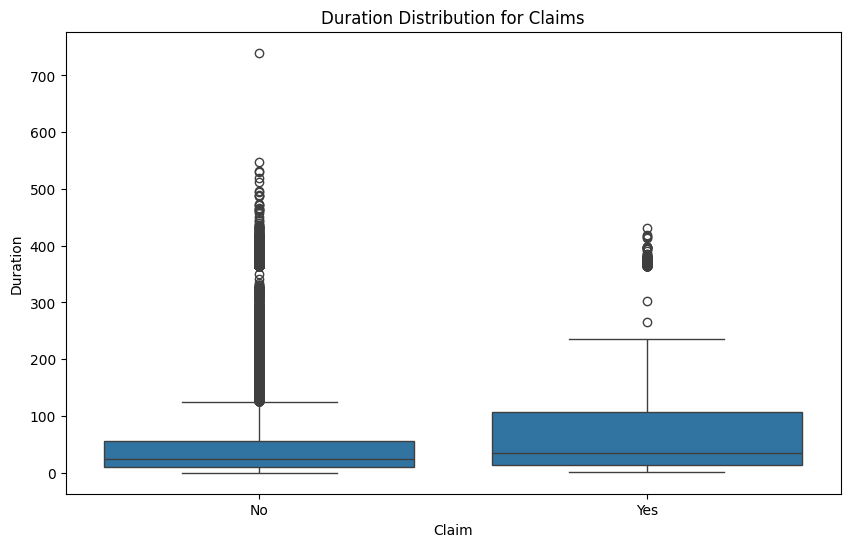

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Claim', y='Duration', data=df)
plt.title('Duration Distribution for Claims')
plt.show()

In [139]:
df[df['Claim']=='Yes']['Net Sales'].sum()

62833.91

In [140]:
df[df['Claim']=='No']['Net Sales'].sum()

1625607.52

In [141]:
df[df['Claim']=='Yes']['Commision (in value)'].sum()

17419.35

In [142]:
df[df['Claim']=='No']['Commision (in value)'].sum()

379459.52

## 4.7 Inferential Statistics

### 4.7.1. There is a significant difference in the mean duration between claims and no claims
This indicates that the average duration of travel (as recorded in dataset) is different for policies that resulted in a claim versus those that did not. The word "significant" here means that this difference is not likely due to random chance. For example, if the average duration for claims is 20 days and for no claims is 15 days, and this difference is statistically significant, it suggests that longer durations may be associated with a higher likelihood of a claim.


In [66]:
from scipy.stats import ttest_ind, chi2_contingency

# Perform t-Test for Duration between Claim Yes/No
claim_yes_duration = df[df['Claim'] == 'Yes']['Duration']
claim_no_duration = df[df['Claim'] == 'No']['Duration']
t_stat, p_val = ttest_ind(claim_yes_duration, claim_no_duration)

# Print results for t-Test
print("t-Test for Duration between Claim Yes/No")
print(f"Null Hypothesis (H0): There is no difference in the mean duration between claims and no claims.")
print(f"Alternative Hypothesis (H1): There is a significant difference in the mean duration between claims and no claims.")
print(f"t-statistic = {t_stat}, p-value = {p_val}")

if p_val < 0.05:
    print("Result: Reject the null hypothesis. There is a significant difference in the mean duration between claims and no claims.\n")
else:
    print("Result: Fail to reject the null hypothesis. There is no significant difference in the mean duration between claims and no claims.\n")

t-Test for Duration between Claim Yes/No
Null Hypothesis (H0): There is no difference in the mean duration between claims and no claims.
Alternative Hypothesis (H1): There is a significant difference in the mean duration between claims and no claims.
t-statistic = 19.822158033611085, p-value = 5.171604708722798e-87
Result: Reject the null hypothesis. There is a significant difference in the mean duration between claims and no claims.



### 4.7.2 There is a significant association between Agency Type and Claim status

This indicates that the type of agency (e.g., Airlines, Travel Agencies) is related to whether or not a claim was made. In other words, some types of agencies might have a higher or lower proportion of claims compared to others. The statistical significance means this relationship is unlikely to have occurred by chance and suggests that the type of agency may influence the likelihood of claims.

In [67]:
# Perform Chi-Square Test for Agency Type and Claim Status
contingency_table = pd.crosstab(df['Agency Type'], df['Claim'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results for Chi-Square Test
print("Chi-Square Test for Association between Agency Type and Claim Status")
print(f"Null Hypothesis (H0): There is no association between Agency Type and Claim status.")
print(f"Alternative Hypothesis (H1): There is a significant association between Agency Type and Claim status.")
print(f"Chi-square statistic = {chi2}, p-value = {p}, degrees of freedom = {dof}")

if p < 0.05:
    print("Result: Reject the null hypothesis. There is a significant association between Agency Type and Claim status.\n")
else:
    print("Result: Fail to reject the null hypothesis. There is no significant association between Agency Type and Claim status.\n")

Chi-Square Test for Association between Agency Type and Claim Status
Null Hypothesis (H0): There is no association between Agency Type and Claim status.
Alternative Hypothesis (H1): There is a significant association between Agency Type and Claim status.
Chi-square statistic = 429.6189858471441, p-value = 1.9670519265789856e-95, degrees of freedom = 1
Result: Reject the null hypothesis. There is a significant association between Agency Type and Claim status.



### 4.7.3 There is a significant association between Agency and Claim status

Similar to the previous statement but more specific, this means that there is a relationship between the specific agencies (e.g., different company names) and whether a claim was made. Some agencies may have a higher rate of claims, while others have a lower rate. The significance indicates that this pattern is likely not random but reflects a true relationship in the data.

In [68]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['Agency'], df['Claim'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: chi2 = {chi2}, p-value = {p}")
if p < 0.05:
    print("There is a significant association between Agency and Claim status.")
else:
    print("There is no significant association between Agency and Claim status.")

Chi-Square Test: chi2 = 1340.9691751963817, p-value = 8.23876668196554e-277
There is a significant association between Agency and Claim status.


### 4.7.4 There is a significant difference in Net Sales between agencies
This suggests that the average `Net Sales` figures differ across various agencies. Some agencies might be generating significantly higher or lower sales than others. The significance means that these differences are statistically validated, meaning they are not likely due to random variation in the data.

In [69]:
from scipy.stats import f_oneway

# Perform ANOVA for Net Sales across Agencies
sales_by_agency = [df[df['Agency'] == agency]['Net Sales'] for agency in df['Agency'].unique()]
f_stat, p_val = f_oneway(*sales_by_agency)

print(f"ANOVA for Net Sales: F-statistic = {f_stat}, p-value = {p_val}")
if p_val < 0.05:
    print("There is a significant difference in Net Sales between agencies.")
else:
    print("There is no significant difference in Net Sales between agencies.")

ANOVA for Net Sales: F-statistic = 421.01066390074163, p-value = 0.0
There is a significant difference in Net Sales between agencies.


### 4.7.5 There is a significant difference in the distribution of Net Sales between agencies
This statement indicates that not only the average `Net Sales` differ between agencies, but the entire distribution (i.e., the spread, shape, and variability of sales data) is different across agencies. Some agencies might have a wide range of sales values (high variance), while others have a more concentrated range (low variance). The significance here implies that these differences in distribution are meaningful and not due to random chance.

In [70]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis Test for Net Sales across Agencies
kruskal_stat, p_val = kruskal(*sales_by_agency)

print(f"Kruskal-Wallis Test for Net Sales: H-statistic = {kruskal_stat}, p-value = {p_val}")
if p_val < 0.05:
    print("There is a significant difference in the distribution of Net Sales between agencies.")
else:
    print("There is no significant difference in the distribution of Net Sales between agencies.")

Kruskal-Wallis Test for Net Sales: H-statistic = 3993.5509892916243, p-value = 0.0
There is a significant difference in the distribution of Net Sales between agencies.


### 4.7.6 Summary

- **Significant Difference in Means**: This usually pertains to the average values of a continuous variable (like duration or net sales) being different between two or more groups.
- **Significant Association**: This refers to a relationship or dependency between two categorical variables (like agency type and claim status). A significant association suggests that one variable (e.g., agency type) influences or is related to the other (e.g., claim status).
- **Significant Difference in Distribution**: This looks beyond just the average to consider the entire spread and shape of the data across different groups.

# **Data Preparation**

## Feature Engineering

nambah keterangan

In [77]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age',
       'Claim', 'Age_Group'],
      dtype='object')

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Define numerical and categorical features
numerical_features = ['Duration', 'Net Sales', 'Commision (in value)', 'Age']
categorical_features = ['Agency','Agency Type','Product Name', 'Distribution Channel','Age_Group','Destination']

In [79]:
# Numerical transformation (scaling + optional log transformation)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler()),
    ('log_transform', FunctionTransformer(np.log1p))  # Optional: Log transform for skewed data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [80]:
numerical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('log_transform', FunctionTransformer(func=<ufunc 'log1p'>))])

In [81]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [82]:
# Combine numerical and categorical transformers into a preprocessor
transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [83]:
transformer

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<ufunc 'log1p'>))]),
                                 ['Duration', 'Net Sales',
                                  'Commision (in value)', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Agency', 'Agency Type', 'Product Name',
                                  'Distribution Channel', 'Age_Group',
                                  'Destination'])])

## Data Splitting

In [84]:
# Split the data into training and test sets
X = df.drop(columns=['Claim'])
y = df['Claim'].map({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
transformed_data = transformer.fit_transform(X_train)
print(f"Shape of transformed data: {transformed_data.shape}")

Shape of transformed data: (31064, 187)


# 6. Modeling & Evaluation

## 6.1 Experiment Model Base with Best Performance

To determine wether the model is good or not, we use metric evaluation. The use of metrics like mean roc_auc, sdev, and roc_auc score is crucial for determining the best model because each metric provides different insights into the model's performance:

**1. Mean ROC AUC:**

The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score is a performance metric for classification problems. It measures the model's ability to distinguish between classes. A higher ROC AUC value indicates a better-performing model.The mean ROC AUC across cross-validation folds provides an average measure of the model's performance, helping to understand how well the model performs across different subsets of the data.

**2. Standard Deviation (sdev):**

The standard deviation of the ROC AUC scores across different folds during cross-validation. It indicates the stability and consistency of the model's performance. A lower standard deviation suggests that the model performs consistently across different folds, while a higher standard deviation indicates variability and potential overfitting or sensitivity to the data split.

**3. ROC AUC Score (on test data):**

The ROC AUC score calculated on the test set provides a final measure of the model's performance on unseen data. This score helps in understanding how well the model generalizes to new data. It’s essential to validate that the performance on the test set aligns with the cross-validation results.

### 6.1.1 Experiment 1: Numerical Feature using Standar Scalar and Log Transform, Categorical Feature using OHE

In this experiment, the preprocessing pipeline for numerical features involved the use of a **Standard Scaler**, which standardizes features by removing the mean and scaling to unit variance. Additionally, a **Log Transform** was applied to handle skewed distributions in the numerical features. Categorical features were processed using **One-Hot Encoding (OHE)**, which creates binary columns for each category.

In [86]:
# List of models to evaluate
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    lgb.LGBMClassifier()
]

In [87]:
# Adjust the transformer pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('log_transform', FunctionTransformer(lambda x: np.log1p(np.clip(x, 1e-9, None))))
])

In [88]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [89]:
transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
transformer

#### Model Benchmarking : K-Fold

In [90]:
# Lists to store results
score = []
rata = []
std = []

In [91]:
# Cross-validation with Stratified KFold
for model in models:
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

[LightGBM] [Info] Number of positive: 431, number of negative: 24420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 891
[LightGBM] [Info] Number of data points in the train set: 24851, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017343 -> initscore=-4.037050
[LightGBM] [Info] Start training from score -4.037050
[LightGBM] [Info] Number of positive: 430, number of negative: 24421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 24851, number of used features: 103
[LightGBM] [Info] [bin

In [92]:
# Create a DataFrame with results
results_df = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'mean roc_auc': rata,
    'sdev': std
}).set_index('model').sort_values(by='mean roc_auc', ascending=False)

results_df

,mean roc_auc,sdev
model,,
Logistic Regression,0.806225,0.017509
LightGBM,0.777944,0.025998
XGBoost,0.764305,0.019456
Random Forest,0.675667,0.018839
Decision Tree,0.584796,0.012239
KNN,0.578238,0.013887


#### Model Benchmarking : Test Data

In [93]:
# List to store ROC AUC scores
score_roc_auc = []

# Function to fit the model and predict on the test set
def y_pred_func(model):
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    
    # Fit the model
    estimator.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = estimator.predict(X_test)
    return estimator, y_pred, X_test

# Benchmarking models
for model, name in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']):
    estimator, y_pred, X_test = y_pred_func(model)
    y_predict_proba = estimator.predict_proba(X_test)[:, 1]
    score_roc_auc.append(roc_auc_score(y_test, y_predict_proba))
    print(f"{name}\n{classification_report(y_test, y_pred)}\n")

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7632
           1       0.00      0.00      0.00       135

    accuracy                           0.98      7767
   macro avg       0.49      0.50      0.50      7767
weighted avg       0.97      0.98      0.97      7767


KNN
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7632
           1       0.00      0.00      0.00       135

    accuracy                           0.98      7767
   macro avg       0.49      0.50      0.50      7767
weighted avg       0.97      0.98      0.97      7767


Decision Tree
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7632
           1       0.09      0.04      0.06       135

    accuracy                           0.98      7767
   macro avg       0.54      0.52      0.52      7767
weighted avg       0.97      0.98 

In [94]:
# Create a DataFrame to display ROC AUC scores
results_df_test_data = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'roc_auc score': score_roc_auc
}).set_index('model').sort_values(by='roc_auc score', ascending=False)

results_df_test_data

,roc_auc score
model,
Logistic Regression,0.815739
LightGBM,0.798055
XGBoost,0.783908
Random Forest,0.680277
KNN,0.603620
Decision Tree,0.568432


### 6.1.2 Experiment 2: Numerical Feature using Standard Scalar and Categorical Features Perform Binary Encoding and One Hot Encoding

For Experiment 2, the numerical features were again scaled using the **Standard Scaler** to ensure consistency across experiments. Categorical features, however, were transformed using a combination of **Binary Encoding** and **One-Hot Encoding (OHE)**. Binary Encoding reduces the dimensionality of categorical variables compared to One-Hot Encoding, while still capturing the relationship between categories and the target variable.

In [95]:
from category_encoders import BinaryEncoder

# Define numerical and categorical features
numerical_features = ['Duration', 'Net Sales', 'Commision (in value)', 'Age']
binary_encoded_features = ['Agency', 'Product Name', 'Destination']
onehot_encoded_features = ['Agency Type', 'Distribution Channel','Age_Group']

# Binary encoding transformer for high-cardinality features
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary', BinaryEncoder())
])

# One-Hot encoding transformer for the remaining categorical features
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical transformers into a preprocessor
transformer_exp2 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('binary', binary_transformer, binary_encoded_features),
        ('onehot', onehot_transformer, onehot_encoded_features)
    ])

In [96]:
transformer_exp2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000017D5ACE6020>))]),
                                 ['Duration', 'Net Sales',
                                  'Commision (in value)', 'Age']),
                                ('binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder())]),
                                 ['Agency', 'Product Name', 'Destination']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Agency Type', 'Distribution Channel',
                                  'Age_Group'])])

#### Model Benchmarking : K-Fold

In [97]:
# Lists to store results
score_exp2 = []
rata_exp2 = []
std_exp2 = []

# Cross-validation with Stratified KFold
for model in models:
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('preprocess', transformer_exp2),
        ('model', model)
    ])
    model_cv_exp2 = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='roc_auc')
    score_exp2.append(model_cv_exp2)
    rata_exp2.append(model_cv_exp2.mean())
    std_exp2.append(model_cv_exp2.std())

[LightGBM] [Info] Number of positive: 431, number of negative: 24420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 24851, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017343 -> initscore=-4.037050
[LightGBM] [Info] Start training from score -4.037050
[LightGBM] [Info] Number of positive: 430, number of negative: 24421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 24851, number of used features: 30
[LightGBM] [Info] [binar

In [98]:
# Create a DataFrame with results
results_df_exp2 = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'mean roc_auc': rata_exp2,
    'sdev': std_exp2
}).set_index('model').sort_values(by='mean roc_auc', ascending=False)

results_df_exp2

,mean roc_auc,sdev
model,,
Logistic Regression,0.802592,0.015131
LightGBM,0.778235,0.017490
XGBoost,0.763730,0.018863
Random Forest,0.672740,0.019027
Decision Tree,0.584926,0.018398
KNN,0.581775,0.012096


#### Model Benchmarking : Test Data

In [99]:
# List to store ROC AUC scores
score_roc_auc_exp2 = []

# Function to fit the model and predict on the test set
def y_pred_func(model):
    estimator = Pipeline([
        ('preprocess', transformer_exp2),
        ('model', model)
    ])
    
    # Fit the model
    estimator.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = estimator.predict(X_test)
    return estimator, y_pred, X_test

# Benchmarking models
for model, name in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']):
    estimator, y_pred, X_test = y_pred_func(model)
    y_predict_proba = estimator.predict_proba(X_test)[:, 1]
    score_roc_auc_exp2.append(roc_auc_score(y_test, y_predict_proba))
    print(f"{name}\n{classification_report(y_test, y_pred)}\n")

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7632
           1       0.00      0.00      0.00       135

    accuracy                           0.98      7767
   macro avg       0.49      0.50      0.50      7767
weighted avg       0.97      0.98      0.97      7767


KNN
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7632
           1       0.00      0.00      0.00       135

    accuracy                           0.98      7767
   macro avg       0.49      0.50      0.50      7767
weighted avg       0.97      0.98      0.97      7767


Decision Tree
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7632
           1       0.09      0.05      0.07       135

    accuracy                           0.97      7767
   macro avg       0.54      0.52      0.53      7767
weighted avg       0.97      0.97 

In [100]:
# Create a DataFrame to display ROC AUC scores
results_df_test_data_exp2 = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'roc_auc score': score_roc_auc_exp2
}).set_index('model').sort_values(by='roc_auc score', ascending=False)

results_df_test_data_exp2

,roc_auc score
model,
Logistic Regression,0.823653
LightGBM,0.796257
XGBoost,0.776014
Random Forest,0.685407
KNN,0.592792
Decision Tree,0.567192


### 6.1.3 Experiment 3: Robust Scalar and Power Transformer, with Binary Encoding and OHE

In the third experiment, the preprocessing approach for numerical features included the use of a **Robust Scaler** and a **Power Transformer**. The Robust Scaler is less sensitive to outliers than the Standard Scaler, making it a good choice for data with significant outliers. The Power Transformer (using the Yeo-Johnson method) was applied to reduce skewness and stabilize variance. Categorical features were processed using the same combination of **Binary Encoding** and **One-Hot Encoding (OHE)** as in Experiment 2.

In [101]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

# Numerical transformation (scaling + optional log transformation)
numerical_transformer_exp3 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', RobustScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))  # Optional: Log transform for skewed data
])

In [102]:
# Combine numerical and categorical transformers into a preprocessor
transformer_exp3 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_exp3, numerical_features),
        ('binary', binary_transformer, binary_encoded_features),
        ('onehot', onehot_transformer, onehot_encoded_features)
    ])

In [103]:
transformer_exp3

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler()),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['Duration', 'Net Sales',
                                  'Commision (in value)', 'Age']),
                                ('binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder())]),
                                 ['Agency', 'Product Name', 'Destination']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Agency Type', 'Distribution Channel',
                                  'Age_Group'])])

#### Model Benchmarking : K-Fold

In [104]:
# Lists to store results
score_exp3 = []
rata_exp3 = []
std_exp3 = []

# Cross-validation with Stratified KFold
for model in models:
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('preprocess', transformer_exp3),
        ('model', model)
    ])
    model_cv_exp3 = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='roc_auc')
    score_exp3.append(model_cv_exp3)
    rata_exp3.append(model_cv_exp3.mean())
    std_exp3.append(model_cv_exp3.std())

[LightGBM] [Info] Number of positive: 431, number of negative: 24420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 24851, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017343 -> initscore=-4.037050
[LightGBM] [Info] Start training from score -4.037050
[LightGBM] [Info] Number of positive: 430, number of negative: 24421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 893
[LightGBM] [Info] Number of data points in the train set: 24851, number of used features: 30
[LightGBM] [Info] [binar

In [105]:
# Create a DataFrame with results
results_df_exp3 = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'mean roc_auc': rata_exp3,
    'sdev': std_exp3
}).set_index('model').sort_values(by='mean roc_auc', ascending=False)

results_df_exp3

,mean roc_auc,sdev
model,,
Logistic Regression,0.813343,0.013741
LightGBM,0.795510,0.021395
XGBoost,0.776413,0.023241
Random Forest,0.695804,0.017461
KNN,0.588312,0.010837
Decision Tree,0.530985,0.011858


#### Model Benchmarking : Test Data

In [106]:
# List to store ROC AUC scores
score_roc_auc_exp3 = []

# Function to fit the model and predict on the test set
def y_pred_func(model):
    estimator = Pipeline([
        ('preprocess', transformer_exp3),
        ('model', model)
    ])
    
    # Fit the model
    estimator.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = estimator.predict(X_test)
    return estimator, y_pred, X_test

# Benchmarking models
for model, name in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']):
    estimator, y_pred, X_test = y_pred_func(model)
    y_predict_proba = estimator.predict_proba(X_test)[:, 1]
    score_roc_auc_exp3.append(roc_auc_score(y_test, y_predict_proba))
    print(f"{name}\n{classification_report(y_test, y_pred)}\n")

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7632
           1       0.00      0.00      0.00       135

    accuracy                           0.98      7767
   macro avg       0.49      0.50      0.50      7767
weighted avg       0.97      0.98      0.97      7767


KNN
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7632
           1       0.00      0.00      0.00       135

    accuracy                           0.98      7767
   macro avg       0.49      0.50      0.50      7767
weighted avg       0.97      0.98      0.97      7767


Decision Tree
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7632
           1       0.04      0.06      0.05       135

    accuracy                           0.96      7767
   macro avg       0.51      0.52      0.51      7767
weighted avg       0.97      0.96 

In [107]:
# Create a DataFrame to display ROC AUC scores
results_df_test_data_exp3 = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'roc_auc score': score_roc_auc_exp3
}).set_index('model').sort_values(by='roc_auc score', ascending=False)

results_df_test_data_exp3

,roc_auc score
model,
Logistic Regression,0.824501
LightGBM,0.813245
XGBoost,0.772614
Random Forest,0.689779
KNN,0.575453
Decision Tree,0.523618


In [108]:
# Combine all DataFrames
combined_results = pd.concat([
    results_df[['mean roc_auc', 'sdev']].add_suffix('_exp1_train'),
    results_df_test_data[['roc_auc score']].add_suffix('_exp1_test'),
    results_df_exp2[['mean roc_auc', 'sdev']].add_suffix('_exp2_train'),
    results_df_test_data_exp2[['roc_auc score']].add_suffix('_exp2_test'),
    results_df_exp3[['mean roc_auc', 'sdev']].add_suffix('_exp3_train'),
    results_df_test_data_exp3[['roc_auc score']].add_suffix('_exp3_test'),
], axis=1)

In [109]:
combined_results

,mean roc_auc_exp1_train,sdev_exp1_train,roc_auc score_exp1_test,mean roc_auc_exp2_train,sdev_exp2_train,roc_auc score_exp2_test,mean roc_auc_exp3_train,sdev_exp3_train,roc_auc score_exp3_test
model,,,,,,,,,
Logistic Regression,0.806225,0.017509,0.815739,0.802592,0.015131,0.823653,0.813343,0.013741,0.824501
LightGBM,0.777944,0.025998,0.798055,0.778235,0.017490,0.796257,0.795510,0.021395,0.813245
XGBoost,0.764305,0.019456,0.783908,0.763730,0.018863,0.776014,0.776413,0.023241,0.772614
Random Forest,0.675667,0.018839,0.680277,0.672740,0.019027,0.685407,0.695804,0.017461,0.689779
Decision Tree,0.584796,0.012239,0.568432,0.584926,0.018398,0.567192,0.530985,0.011858,0.523618
KNN,0.578238,0.013887,0.603620,0.581775,0.012096,0.592792,0.588312,0.010837,0.575453


<Figure size 1200x800 with 0 Axes>

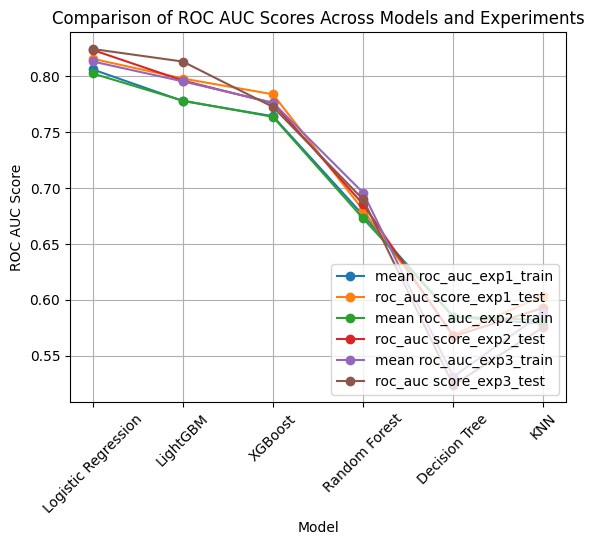

In [110]:
# Plotting the line chart for comparison
plt.figure(figsize=(12, 8))
combined_results.drop(columns=['sdev_exp1_train','sdev_exp2_train','sdev_exp3_train']).plot(kind='line', marker='o')

plt.title('Comparison of ROC AUC Scores Across Models and Experiments')
plt.ylabel('ROC AUC Score')
plt.xlabel('Model')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='lower right')

plt.show()

Logistic Regression, LightGBM, and XGBoost consistently show higher ROC AUC scores across all experiments compared to other models, indicating they are more effective at distinguishing between classes.

KNN consistently underperforms across all experiments, having the lowest ROC AUC scores, both in training and testing, which suggests that it's not a suitable model for this problem.

## 6.2 Model Improvement : Logistic Regression

### 6.2.1 Handling Imbalance using SMOTE

SMOTE generates synthetic samples by interpolating between existing samples of the minority class, rather than simply duplicating them. It’s widely used because it creates new, slightly different instances, which helps prevent overfitting.

Class Imbalance: The target variable (Claim status) has a significant imbalance (90% No and 10% Yes), the model might perform well in terms of overall accuracy but poorly in predicting the minority class (Yes in this case).

Improving Recall for the Minority Class: If it’s important to correctly identify instances of the minority class (predicting claims correctly is critical), oversampling can help the model focus more on that class.

In [111]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the SMOTE oversampler
smote = SMOTE(random_state=42)

# Integrate into the pipeline
pipeline = ImbPipeline(steps=[
    ('preprocess', transformer_exp3),  
    ('smote', smote),
    ('model', LogisticRegression())
])

# Cross-validation with StratifiedKFold to keep class balance in the folds
skfold = StratifiedKFold(n_splits=5)
model_cv = cross_val_score(pipeline, X_train, y_train, cv=skfold, scoring='roc_auc')

# Print results
print(f'Mean ROC AUC: {model_cv.mean():.4f}')
print(f'Standard Deviation: {model_cv.std():.4f}')

# Fit the model and evaluate on test data
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC AUC on Test Data: {roc_auc:.4f}')
print(classification_report(y_test, y_pred))


Mean ROC AUC: 0.8086
Standard Deviation: 0.0157
ROC AUC on Test Data: 0.8261
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      7632
           1       0.06      0.71      0.10       135

    accuracy                           0.79      7767
   macro avg       0.52      0.75      0.49      7767
weighted avg       0.98      0.79      0.87      7767



In [112]:
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['Duration', 'Net Sales',
                                                   'Commision (in value)',
                                                   'Age']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Agency', 'Product Name',
                                                   'Destination']),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distribution Channel',
                                                   'Age_Group'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression())])

In [113]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, classification_report

# Function to calculate training error
def calc_train_error(X_train, y_train, model):
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

# Function to calculate validation error
def calc_validation_error(X_test, y_test, model):
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

# Function to fit model and calculate metrics
def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

# Assuming you already have X_train, y_train, X_test, y_test, and pipeline set up
train_error, validation_error = calc_metrics(X_train, y_train, X_test, y_test, pipeline)

# Print out the metrics
print("Training Error Metrics:")
for key, value in train_error.items():
    print(f"{key}: {value}")

print("\nValidation Error Metrics:")
for key, value in validation_error.items():
    print(f"{key}: {value}")

Training Error Metrics:
report:               precision    recall  f1-score   support

           0       0.99      0.79      0.88     30526
           1       0.06      0.73      0.11       538

    accuracy                           0.79     31064
   macro avg       0.53      0.76      0.50     31064
weighted avg       0.98      0.79      0.87     31064

f1: 0.49553950807847164
roc: 0.8247079337815993
accuracy: 0.7921066185938708
recall: 0.7323420074349443
precision: 0.05873583780560525

Validation Error Metrics:
report:               precision    recall  f1-score   support

           0       0.99      0.79      0.88      7632
           1       0.06      0.71      0.10       135

    accuracy                           0.79      7767
   macro avg       0.52      0.75      0.49      7767
weighted avg       0.98      0.79      0.87      7767

f1: 0.49137921869902523
roc: 0.8260904379221989
accuracy: 0.7866615166731041
recall: 0.7111111111111111
precision: 0.056009334889148193


### 6.2.2 Handling Imbalance Using Oversampler ADASYN

ADASYN (Adaptive Synthetic Sampling) is an advanced technique for handling class imbalance in datasets. Imbalance occurs when one class significantly outnumbers the other(s), which can lead to biased model predictions. ADASYN is a variation of the Synthetic Minority Over-sampling Technique (SMOTE), but it goes a step further by adapting the synthetic data generation process based on the difficulty of classifying minority class instances.

- **Focus on Difficult Areas**: Unlike basic oversampling methods that treat all minority instances equally, ADASYN focuses on the more challenging regions of the feature space. This helps improve the classifier's ability to correctly identify the minority class in these difficult regions.
  
- **Better Generalization**: By focusing on harder-to-classify instances, ADASYN can help create a more generalizable model that performs better on unseen data.

- **Reduction of Overfitting**: Since ADASYN generates synthetic data in a more targeted manner, it can help reduce the risk of overfitting compared to other oversampling techniques like SMOTE.

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN

# Definisikan parameter yang ingin dihypertuning
param_grid = {
    'model__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'model__penalty': ['l2'],  # Penalty l1 sering digunakan dengan solver tertentu
    'model__solver': ['lbfgs', 'liblinear']  # Solver lbfgs dan liblinear sering digunakan
}
# Define the ADASYN oversampler
adasyn = ADASYN(random_state=42)

# Buat model Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=10000)

# Buat pipeline
pipeline = ImbPipeline(steps=[
    ('preprocess', transformer_exp3),  # Menggunakan preprocessing steps yang sama
    ('adasyn', adasyn),                  # Oversampling dengan SMOTE
    ('model', logreg)
])

# Definisikan StratifiedKFold
skfold = StratifiedKFold(n_splits=5)

# Gunakan GridSearchCV untuk menemukan parameter terbaik
grid_search = GridSearchCV(pipeline, param_grid, cv=skfold, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Output hasil terbaik
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Gunakan model terbaik pada data uji
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC on Test Data: {roc_auc:.4f}")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best ROC AUC score:  0.8111007672967666
ROC AUC on Test Data: 0.8271
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      7632
           1       0.06      0.73      0.11       135

    accuracy                           0.79      7767
   macro avg       0.53      0.76      0.49      7767
weighted avg       0.98      0.79      0.86      7767



### 6.2.3 Handling Imbalance using Resampling Method

Resampling is a common technique used to address class imbalance in datasets by either upsampling the minority class or downsampling the majority class. The goal is to create a more balanced distribution of classes, which can lead to more accurate and fair predictions. **Upsampling** involves duplicating or generating synthetic samples for the minority class, while **downsampling** reduces the number of majority class samples.

In our context, resampling can be implemented within a machine learning pipeline to ensure that the model does not become biased towards the majority class. This approach is especially useful in scenarios where the minority class is underrepresented, which can cause the model to overlook important patterns in this class. By incorporating resampling, we can improve the model's ability to correctly predict instances of the minority class, leading to better overall performance.

In [115]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report

# Define the resampling method and model
oversampler = RandomOverSampler(random_state=42)  # or SMOTE(random_state=42)
logreg = LogisticRegression()

# Combine preprocessing, resampling, and model into a pipeline
pipeline = ImbPipeline([
    ('resample', oversampler),         # Resampling method
    ('preprocess', transformer_exp3),  
    ('model', logreg)                  # Logistic Regression model
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    'model__solver': ['lbfgs', 'liblinear', 'saga']
}

# Perform GridSearchCV with StratifiedKFold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=skfold, scoring='precision')
grid_search.fit(X_train, y_train)

# Best parameters and model performance
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Best parameters found:", grid_search.best_params_)
print("Precision on Test Data:", precision_score(y_test, y_pred))
print("Recall on Test Data:", recall_score(y_test, y_pred))
print("ROC AUC on Test Data:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best parameters found: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Precision on Test Data: 0.063257065948856
Recall on Test Data: 0.6962962962962963
ROC AUC on Test Data: 0.8224391451199629

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      7632
           1       0.06      0.70      0.12       135

    accuracy                           0.82      7767
   macro avg       0.53      0.76      0.51      7767
weighted avg       0.98      0.82      0.88      7767



## Hypertuning Parameter in Logistic Regression

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tuning 1

**Parameter Grid:**

    1. C Parameter: The C parameter in Logistic Regression is the inverse of regularization strength. A small value of C means stronger regularization. By including a wide range of C values ([0.001, 0.01, 0.1, 1, 10]), this setup aims to explore the impact of varying degrees of regularization on model performance.

    2. Penalty Options: This setup explores three types of penalties: l2 (Ridge), l1 (Lasso), and elasticnet (a combination of L1 and L2). These penalties help to prevent overfitting by adding regularization to the loss function.

    3. Solver Options: The setup includes three different solvers: lbfgs, liblinear, and saga. Each solver has different optimization approaches, and some are better suited for certain data characteristics, such as sparsity or large datasets. Including multiple solvers allows the grid search to determine the best one for the given problem.

**Scope of Search:**

    This tuning setup has a broad search space, which means it is more likely to find an optimal combination of hyperparameters. However, it also means the tuning process will be more computationally expensive and time-consuming.

**Potential Outcomes:**

    1. Model Flexibility: The wide range of C values and different penalties could allow the model to better adapt to various levels of bias-variance trade-offs.

    2. Exhaustiveness: By trying multiple solvers and penalties, this tuning process ensures that the model is optimized across different regularization techniques and optimization strategies.

    3. Computational Cost: Given the large parameter grid, this setup might be more computationally intensive, potentially requiring more time and resources to complete.

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.pipeline import Pipeline as ImbPipeline

# Definisikan parameter yang ingin dihypertuning
param_grid = {
    'model__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'model__penalty': ['l2'],  # Penalty l1 sering digunakan dengan solver tertentu
    'model__solver': ['lbfgs', 'liblinear']  # Solver lbfgs dan liblinear sering digunakan
}

# Buat model Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=10000)

# Buat pipeline
pipeline = ImbPipeline(steps=[
    ('preprocess', transformer_exp3),  # Menggunakan preprocessing steps yang sama
    ('smote', smote),                  # Oversampling dengan SMOTE
    ('model', logreg)
])

# Definisikan StratifiedKFold
skfold = StratifiedKFold(n_splits=5)

# Gunakan GridSearchCV untuk menemukan parameter terbaik
grid_search = GridSearchCV(pipeline, param_grid, cv=skfold, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Output hasil terbaik
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Gunakan model terbaik pada data uji
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC on Test Data: {roc_auc:.4f}")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best ROC AUC score:  0.8112539252887391
ROC AUC on Test Data: 0.8261
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      7632
           1       0.06      0.72      0.11       135

    accuracy                           0.80      7767
   macro avg       0.53      0.76      0.50      7767
weighted avg       0.98      0.80      0.87      7767



### Tuning 2

**Parameter Grid:**

    C Parameter: The C values are still varied but within a different range ([0.01, 0.1, 1.0, 10.0, 100.0]). This covers a broad spectrum but skips the very small C values that indicate strong regularization. This range may be more focused on moderate to weak regularization.

    Penalty Option: The penalty is fixed at l2 (Ridge), which is a commonly used penalty that tends to work well with most datasets. By focusing on l2, the setup avoids the need to explore l1 and elasticnet, making the search faster.

    Solver Options: Only two solvers (lbfgs and liblinear) are considered. These solvers are robust and widely used, making this setup more streamlined.

**Scope of Search:**

    The search space in this setup is narrower, making it less computationally expensive. It is designed for faster execution while still exploring the most common and effective hyperparameters.

    This setup is likely to complete quicker but may miss out on some finer adjustments that the first, more exhaustive search could capture.

**Potential Outcomes:**

    Efficiency: This tuning setup is optimized for speed, making it suitable when computational resources or time are limited.

    Practicality: The choice to focus on l2 regularization and fewer solvers suggests a practical approach that assumes these parameters are likely to be effective, potentially sacrificing some flexibility.

    Less Comprehensive: While faster, this tuning process might not capture the absolute best hyperparameters since it doesn’t explore as broad a range of options as the first setup.


In [118]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
param_grid = {
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__penalty': ['l2', 'l1', 'elasticnet'],
        'model__solver': ['lbfgs', 'liblinear', 'saga']
    }

    # Buat pipeline
pipeline = ImbPipeline(steps=[
        ('preprocess', transformer_exp3),  # Menggunakan preprocessing steps yang sama
        ('smote', smote),                  # Oversampling dengan SMOTE
        ('model', logreg)
    ])

    # Create a grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

    # Fit the grid search
grid_search.fit(X_train, y_train)

    # Best parameters and ROC AUC
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best ROC AUC score: {grid_search.best_score_:.4f}')

    # Evaluate on test data with best estimator
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

print(f'ROC AUC on Test Data: {roc_auc_best:.4f}')
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters found: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best ROC AUC score: 0.8115
ROC AUC on Test Data: 0.8260
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      7632
           1       0.06      0.72      0.11       135

    accuracy                           0.80      7767
   macro avg       0.53      0.76      0.50      7767
weighted avg       0.98      0.80      0.87      7767



#### Confusion Matrix

Confusion Matrix Breakdown:

True Positives (TP = 94): These are instances where the model correctly predicted the positive class (Yes Claim). Out of all the samples that actually had a claim (1), 94 were correctly classified by the model as 1.

True Negatives (TN = 6209): These are instances where the model correctly predicted the negative class (No Claim). Out of all the samples that actually did not have a claim (0), 6209 were correctly classified by the model as 0.

False Positives (FP = 1423): These are instances where the model incorrectly predicted the positive class (Yes Claim). Out of all the samples that actually did not have a claim (0), 1423 were incorrectly classified as 1.

False Negatives (FN = 41): These are instances where the model incorrectly predicted the negative class (No Claim). Out of all the samples that actually had a claim (1), 41 were incorrectly classified as 0.

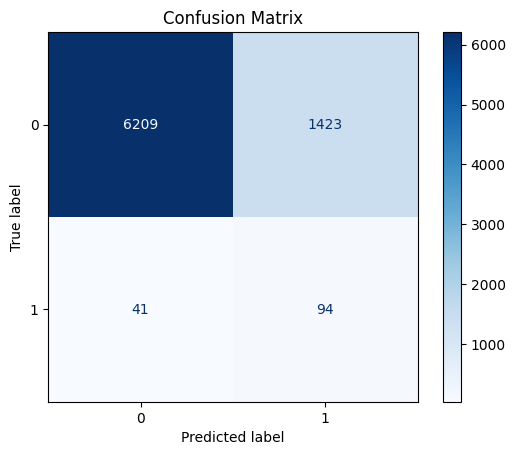

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

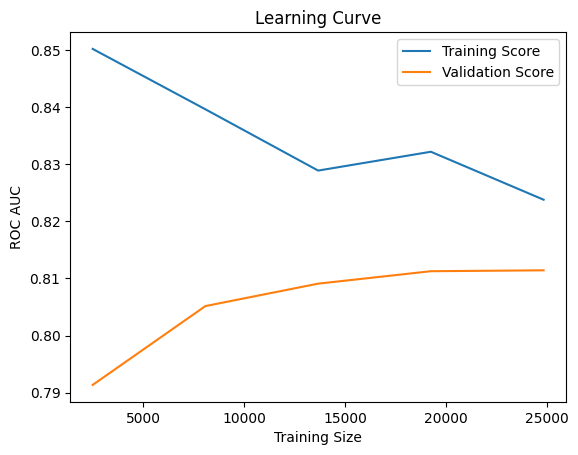

In [120]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.ylabel('ROC AUC')
plt.xlabel('Training Size')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Model Interpretation with Coefission Regression

In [121]:
transformer_exp3

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler()),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['Duration', 'Net Sales',
                                  'Commision (in value)', 'Age']),
                                ('binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder())]),
                                 ['Agency', 'Product Name', 'Destination']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Agency Type', 'Distribution Channel',
                                  'Age_Group'])])

In [145]:
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['Duration', 'Net Sales',
                                                   'Commision (in value)',
                                                   'Age']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Agency', 'Product Name',
                                                   'Destination']),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distribution Channel',
                                                   'Age_Group'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=0.01, max_iter=10000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [148]:
import numpy as np

# Access the logistic regression model within the pipeline
logreg_model = best_model.named_steps['model']

# Get the coefficients
coef = logreg_model.coef_[0]

# Calculate the odds ratios
odds_ratios = np.exp(coef)

# Print the odds ratios
odds_ratios

array([0.98213455, 1.62253415, 1.72011292, 0.95844087, 1.        ,
       1.        , 0.41443247, 0.13111981, 1.        , 0.80790547,
       0.51500772, 0.75308975, 0.71001087, 0.63106968, 1.        ,
       1.        , 0.74592198, 0.9968789 , 1.        , 0.77640426,
       1.09840836, 1.43358292, 1.20061672, 1.        , 1.        ,
       1.        , 1.        , 1.21514149, 1.02843229, 1.        ,
       1.        ])

In [152]:
import pandas as pd
import numpy as np

# Assuming `pipeline` is your trained pipeline

# Extract the preprocessing step from the pipeline
preprocessor = best_model.named_steps['preprocess']

# Get the feature names after preprocessing
feature_names = []
for transformer in preprocessor.transformers_:
    if hasattr(transformer[1], 'get_feature_names_out'):
        feature_names.extend(transformer[1].get_feature_names_out())
    else:
        feature_names.extend(transformer[2])

# Calculate odds ratios
odds_ratios = np.exp(logreg_model.coef_[0])

# Combine feature names with their corresponding odds ratios
feature_odds_ratios = dict(zip(feature_names, odds_ratios))

# Create a DataFrame
odds_ratios_df = pd.DataFrame(list(feature_odds_ratios.items()), columns=['Feature', 'Odds Ratio'])

# Sort the DataFrame in descending order by Odds Ratio
odds_ratios_df_sorted = odds_ratios_df.sort_values(by='Odds Ratio', ascending=False)

# Display the sorted DataFrame
odds_ratios_df_sorted

,Feature,Odds Ratio
2,Commision (in value),1.720113
1,Net Sales,1.622534
21,2_7,1.433583
27,Age_Group_19-35,1.215141
22,Agency Type_Airlines,1.200617
20,2_6,1.098408
28,Age_Group_36-50,1.028432
15,2_1,1.000000
29,Age_Group_51-65,1.000000
26,Age_Group_0-18,1.000000


# Kesimpulan

## Analisis Model Berdasarkan Classification Report

Berdasarkan hasil dari classification report model yang telah dibuat, kita dapat menyimpulkan bahwa model ini memiliki kemampuan untuk memprediksi dengan cukup baik, meskipun terdapat beberapa kekurangan yang perlu diperhatikan, terutama terkait dengan ketidakseimbangan (imbalance) pada dataset.

**Kesimpulan Utama**:
- **Recall untuk Kelas 1 (Yes)**: Model memiliki recall sebesar 0.72 untuk klaim yang disetujui (kelas Yes). Ini berarti model mampu mengidentifikasi 72% dari klaim yang benar-benar terjadi, namun ada 28% klaim yang terlewatkan.
- **Precision untuk Kelas 1 (Yes)**: Precision untuk klaim yang disetujui adalah 0.06, menunjukkan bahwa dari seluruh klaim yang diprediksi akan terjadi oleh model, hanya 6% yang benar-benar terjadi. Ini mengindikasikan bahwa model sering kali salah memprediksi klaim yang seharusnya tidak terjadi.

## Dampak Terhadap Proyeksi Penjualan

Jika kita menerapkan model ini untuk menyaring atau memfilter pelanggan yang kemungkinan akan mengajukan klaim berdasarkan data historis, kita dapat membuat proyeksi mengenai biaya dan penghematan potensial bagi perusahaan. Namun, dengan precision yang rendah, ada risiko tinggi bahwa banyak prediksi klaim tidak akan terjadi, yang dapat mengakibatkan biaya yang tidak perlu dalam pengelolaan klaim tersebut.

**Contoh**:
- Jika biaya untuk setiap klaim yang diproses adalah $100, dan model memprediksi 100 klaim yang ternyata hanya 6 dari mereka yang benar-benar mengajukan klaim, maka akan ada $9400 yang dikeluarkan tanpa hasil (94 klaim palsu dikalikan dengan $100).
  
Meskipun demikian, karena recall yang tinggi, model ini masih dapat membantu dalam mengurangi jumlah klaim yang terlewat, yang berarti potensi kerugian dari klaim yang seharusnya dibayarkan dapat diminimalkan. Sebagai langkah selanjutnya, perusahaan mungkin perlu mempertimbangkan untuk memperbaiki precision dari model ini, misalnya dengan lebih banyak data pelatihan atau teknik penyeimbangan dataset yang lebih efektif.

## Implikasi Model terhadap Net Sales

Hasil dari model yang kita buat memiliki implikasi yang signifikan terhadap net sales, terutama jika kita mempertimbangkan bagaimana model ini digunakan dalam pengambilan keputusan terkait penawaran asuransi atau penanganan klaim.

**Penawaran yang Tepat Sasaran**:
Dengan model yang memiliki recall tinggi tetapi precision rendah, perusahaan mungkin cenderung menawarkan lebih banyak polis kepada pelanggan yang diprediksi akan mengajukan klaim, walaupun banyak dari prediksi tersebut mungkin salah. Ini bisa menyebabkan peningkatan biaya operasional, karena perusahaan harus mengelola lebih banyak klaim yang sebenarnya tidak terjadi. Jika banyak penawaran klaim yang salah dilakukan (false positives), perusahaan mungkin mengalami peningkatan biaya tanpa peningkatan yang proporsional dalam penjualan bersih, karena biaya untuk memproses klaim palsu tersebut tidak menghasilkan pendapatan tambahan.

**Risiko Terhadap Pendapatan**:
Jika perusahaan terlalu banyak mengandalkan prediksi yang salah ini untuk menentukan harga atau keputusan penawaran, perusahaan bisa menetapkan harga yang terlalu tinggi atau rendah secara tidak tepat. Hal ini bisa menyebabkan penurunan dalam penjualan polis, terutama jika pelanggan merasa harga yang ditawarkan terlalu mahal untuk risiko yang mereka rasa tidak sesuai. Sebaliknya, jika perusahaan menggunakan hasil model untuk menolak penawaran kepada pelanggan yang sebenarnya tidak akan mengajukan klaim (false negatives), ini bisa mengurangi potensi pendapatan dari penjualan polis tersebut.

Model ini, dengan kombinasi recall tinggi dan precision rendah, dapat menyebabkan biaya tambahan yang mungkin tidak sebanding dengan peningkatan dalam net sales. Oleh karena itu, penting untuk menyempurnakan model ini lebih lanjut agar dapat memprediksi klaim dengan lebih akurat, sehingga dapat mengoptimalkan penawaran produk yang benar-benar sesuai dengan risiko pelanggan, dan pada akhirnya meningkatkan net sales tanpa mengorbankan efisiensi biaya.
